# JETSCAPE VAH: Bayesian parameter inference for **relativistic heavy ion collisions**

### What's in This Notebook

**1. Physics simulation and preprocessing of the simulation data**

##### Physics model

Simulate relativistic heavy ion collisions for a Latin Hyper Cube design. Load saved simulation data from a folder. Anyone who wish to use the code to do another Bayesian analysis for relativistic heavy ion collision should do minor change to this section that suits    their model and simulation data.

Python modules used

 > pandas

##### Preprocessing and dimensional reduction of the simulation data


We first standardize observables by substracting the mean and scaling it to have unit variance. Then do a Principal Component Analysis (PCA) to reduce the dimensionality of the data. 

Python modules used

 > numpy
 
 > sklearn
             
**2. Load validation and experimental data**

Relevant data is loaded from disk.
           
Python modules used

 > pandas

**3. Building Emulators**

Since the simulations are computationally expensive we need surrogate models that can be trained on a sparse set of simulation data obtained from the full model and are then used to interpolate the model output speedily to any other point in the multi-dimensional parameter space. For this purpose we use Gaussian Processes. They also give the uncertainty in the prediction which is very important to properly account all uncertainties and reliably extract parameters using Bayesian methods. 

Python modules used

 > sklearn
 
 > numpy
                
**4. Bayesian parameter estimation**

The Bayes theorem is used to find the posterior of the model parameters using the emulators and the pseudo experimental data.

Python modules used

> pandas

> numpy

> seaborn

### Import all the necessary libraries that we mention above

In [1]:
import sys
import os
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from numpy.linalg import inv
import sklearn, matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl
import scipy.stats as st
from scipy import optimize

import uncertainty_toolbox as uct

import ptemcee
import h5py
from scipy.linalg import lapack
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
sns.set("notebook")

In [2]:
# Load experimental data
experiment=pd.read_csv(filepath_or_buffer="../HIC_experimental_data/PbPb2760_experiment",index_col=0)

In [3]:
# Gather what type of experimental data do we have. 
exp_label=[]
for i in experiment.columns:
    words=i.split('[')
    exp_label.append(words[0]+'_['+words[1])

In [4]:
model_param_dsgn = ['$N$[$2.76$TeV]',
 '$p$',
 '$w$ [fm]',
 '$d_{\\mathrm{min}}$ [fm]',
 '$\\sigma_k$',
 '$T_{\\mathrm{sw}}$ [GeV]',
 '$T_{\\eta,\\mathrm{kink}}$ [GeV]',
 '$(\\eta/s)_{\\mathrm{kink}}$',
 '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]',
 '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]',
 '$(\\zeta/s)_{\\max}$',
 '$T_{\\zeta,c}$ [GeV]',
 '$w_{\\zeta}$ [GeV]',
 '$\\lambda_{\\zeta}$',
 '$R$']

In [5]:
# save the invese tf matrix to be loaded from streamlit
inverse_tf_matrix= np.load('../emulation/INV_MAT.npy')
SS_mean = np.load('../emulation/SS_MN.npy')

In [6]:
#### Block 12 #### Please refer to this number in your questions
experiment.iloc[:,-20:]

,v22[0 5],v22[ 5 10],v22[10 20],v22[20 30],v22[30 40],v22[40 50],v22[50 60],v22[60 70],v32[0 5],v32[ 5 10],v32[10 20],v32[20 30],v32[30 40],v32[40 50],v42[0 5],v42[ 5 10],v42[10 20],v42[20 30],v42[30 40],v42[40 50]
mean,2.724000e-02,0.044570,0.064030,0.083140,0.094610,0.099410,0.097590,0.090030,2.015000e-02,2.326000e-02,0.026220,0.028840,0.030310,0.030220,9.720000e-03,1.133000e-02,1.250000e-02,1.390000e-02,1.540000e-02,0.015140
variance,4.768000e-07,0.000001,0.000003,0.000002,0.000002,0.000003,0.000003,0.000002,6.922000e-07,8.938000e-07,0.000001,0.000001,0.000002,0.000002,2.362000e-07,4.234000e-07,3.229000e-07,5.345000e-07,7.093000e-07,0.000001


In [7]:
experiment.values.shape

(2, 110)

In [8]:
#### Block 13 #### Please refer to this number in your questions

y_exp= experiment.values[0,:]
y_exp_variance= experiment.values[1,:]
print(f'Shape of the experiment observables {y_exp.shape} and shape of the experimental error variance{y_exp_variance.shape}')

Shape of the experiment observables (110,) and shape of the experimental error variance(110,)


In [9]:
# Save these experimental data for later use by streamlit

#### 2.1: Plot the experimental data

The following 5 cells are used to generate a beautiful plot for the experimental data. Don't worry about them too much! 

In [10]:
#### Block 14 #### Please refer to this number in your questions


from collections import OrderedDict

colors = OrderedDict([
    ('blue', '#4e79a7'),
    ('orange', '#f28e2b'),
    ('green', '#59a14f'),
    ('red', '#e15759'),
    ('cyan', '#76b7b2'),
    ('purple', '#b07aa1'),
    ('brown', '#9c755f'),
    ('yellow', '#edc948'),
    ('pink', '#ff9da7'),
    ('gray', '#bab0ac')
])

fontsize = dict(
    large=11,
    normal=10,
    small=9,
    tiny=8
)

offblack = '.15'

plt.rcdefaults()
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Lato'],
    'mathtext.fontset': 'custom',
    'mathtext.default': 'it',
    'mathtext.rm': 'sans',
    'mathtext.it': 'sans:italic:medium',
    'mathtext.cal': 'sans',
    'font.size': fontsize['normal'],
    'legend.fontsize': fontsize['normal'],
    'axes.labelsize': fontsize['normal'],
    'axes.titlesize': fontsize['large'],
    'xtick.labelsize': fontsize['small'],
    'ytick.labelsize': fontsize['small'],
    #'font.weight': 400,
    'axes.labelweight': 400,
    'axes.titleweight': 400,
    'axes.prop_cycle': plt.cycler('color', list(colors.values())),
    'lines.linewidth': .8,
    'lines.markersize': 3,
    'lines.markeredgewidth': 0,
    'patch.linewidth': .8,
    'axes.linewidth': .6,
    'xtick.major.width': .6,
    'ytick.major.width': .6,
    'xtick.minor.width': .4,
    'ytick.minor.width': .4,
    'xtick.major.size': 3.,
    'ytick.major.size': 3.,
    'xtick.minor.size': 2.,
    'ytick.minor.size': 2.,
    'xtick.major.pad': 3.5,
    'ytick.major.pad': 3.5,
    'axes.labelpad': 4.,
    'axes.formatter.limits': (-5, 5),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'text.color': offblack,
    'axes.edgecolor': offblack,
    'axes.labelcolor': offblack,
    'xtick.color': offblack,
    'ytick.color': offblack,
    'legend.frameon': False,
    'image.cmap': 'Blues',
    'image.interpolation': 'none',
})

def set_tight(fig=None, **kwargs):
    """
    Set tight_layout with a better default pad.

    """
    if fig is None:
        fig = plt.gcf()

    kwargs.setdefault('pad', .1)
    fig.set_tight_layout(kwargs)

In [11]:
#### Block 15 #### Please refer to this number in your questions


# 8 bins
ALICE_cent_bins = np.array([[0,5],[5,10],[10,20],[20,30],[30,40],[40,50],[50,60],[60,70]]) 

obs_cent_list = {
'Pb-Pb-2760': {
    'dNch_deta' : ALICE_cent_bins,
    'dET_deta' : np.array([[0, 2.5], [2.5, 5], [5, 7.5], [7.5, 10],
                           [10, 12.5], [12.5, 15], [15, 17.5], [17.5, 20],
                           [20, 22.5], [22.5, 25], [25, 27.5], [27.5, 30],
                           [30, 32.5], [32.5, 35], [35, 37.5], [37.5, 40],
                           [40, 45], [45, 50], [50, 55], [55, 60],
                           [60, 65], [65, 70]]), # 22 bins
    'dN_dy_pion'   : ALICE_cent_bins,
    'dN_dy_kaon'   : ALICE_cent_bins,
    'dN_dy_proton' : ALICE_cent_bins,
    'dN_dy_Lambda' : np.array([[0,5],[5,10],[10,20],[20,40],[40,60]]), # 5 bins
    'dN_dy_Omega'  : np.array([[0,10],[10,20],[20,40],[40,60]]), # 4 bins
    'dN_dy_Xi'     : np.array([[0,10],[10,20],[20,40],[40,60]]), # 4 bins
    'mean_pT_pion'   : ALICE_cent_bins,
    'mean_pT_kaon'   : ALICE_cent_bins,
    'mean_pT_proton' : ALICE_cent_bins,
    'pT_fluct' : np.array([[0,5],[5,10],[10,15],[15,20], [20,25],[25,30],[30,35],[35,40], [40,45],[45,50],[50,55],[55,60]]), #12 bins
    'v22' : ALICE_cent_bins,
    'v32' : np.array([[0,5],[5,10],[10,20],[20,30], [30,40],[40,50]]), # 6 bins
    'v42' : np.array([[0,5],[5,10],[10,20],[20,30], [30,40],[40,50]]), # 6 bins
    }
}

In [12]:
#### Block 16 #### Please refer to this number in your questions


obs_groups = {'yields' : ['dNch_deta', 'dET_deta', 'dN_dy_pion', 'dN_dy_kaon', 'dN_dy_proton'],
              'mean_pT' : ['mean_pT_pion', 'mean_pT_kaon','mean_pT_proton', ],
              'fluct' : ['pT_fluct'],
              'flows' : ['v22', 'v32', 'v42'],
              }

obs_group_labels = {'yields' : r'$dN_\mathrm{id}/dy_p$, $dN_\mathrm{ch}/d\eta$, $dE_T/d\eta$ [GeV]',
                    'mean_pT' : r'$ \langle p_T \rangle_\mathrm{id}$' + ' [GeV]',
                    'fluct' : r'$\delta p_{T,\mathrm{ch}} / \langle p_T \rangle_\mathrm{ch}$',
                    'flows' : r'$v^{(\mathrm{ch})}_k\{2\} $'}

colors = ['b', 'g', 'r', 'c', 'm', 'tan', 'gray']

obs_tex_labels = {'dNch_deta' : r'$dN_\mathrm{ch}/d\eta$' + ' x 2',
                  'dN_dy_pion' : r'$dN_{\pi}/dy_p$',
                  'dN_dy_kaon' : r'$dN_{K}/dy_p$',
                  'dN_dy_proton' : r'$dN_{p}/dy_p$',
                  'dET_deta' : r'$dE_{T}/d\eta$' + ' x 5',
                  
                  'mean_pT_proton' : r'$\langle p_T \rangle_p$',
                  'mean_pT_kaon' : r'$\langle p_T \rangle_K$',
                  'mean_pT_pion' : r'$\langle p_T \rangle_\pi$',
                 
                  'pT_fluct' : None,
                  'v22' : r'$v^{(\mathrm{ch})}_2\{2\}$',
                  'v32' : r'$v^{(\mathrm{ch})}_3\{2\}$',
                  'v42' : r'$v^{(\mathrm{ch})}_4\{2\}$'}

In [13]:
#### Block 17 #### Please refer to this number in your questions


index={}
st_index=0
for obs_group in  obs_groups.keys():
    for obs in obs_groups[obs_group]:
        #print(obs)
        n_centrality= len(obs_cent_list['Pb-Pb-2760'][obs])
        #print(n_centrality)
        index[obs]=[st_index,st_index+n_centrality]
        st_index = st_index+n_centrality
print(index)

{'dNch_deta': [0, 8], 'dET_deta': [8, 30], 'dN_dy_pion': [30, 38], 'dN_dy_kaon': [38, 46], 'dN_dy_proton': [46, 54], 'mean_pT_pion': [54, 62], 'mean_pT_kaon': [62, 70], 'mean_pT_proton': [70, 78], 'pT_fluct': [78, 90], 'v22': [90, 98], 'v32': [98, 104], 'v42': [104, 110]}


No handles with labels found to put in legend.
/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Done


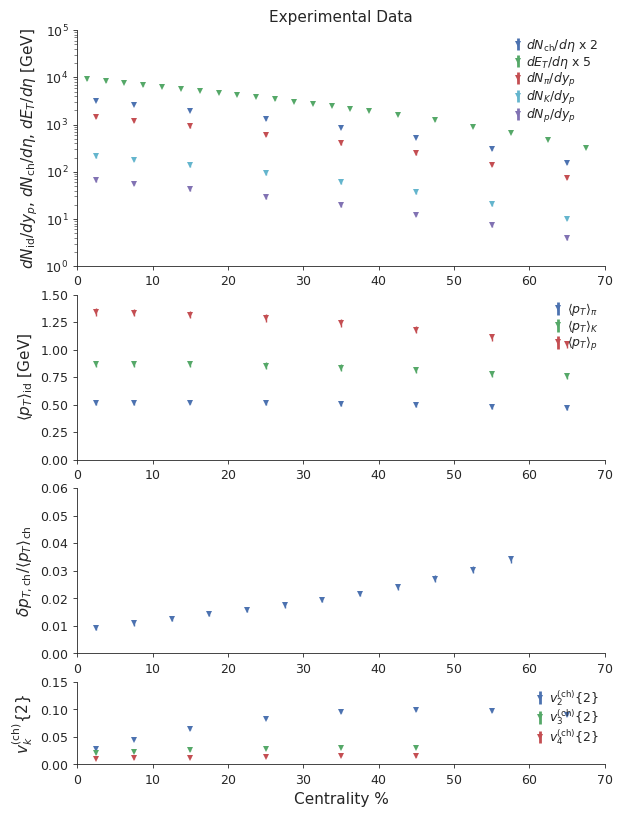

In [14]:
#### Block 18 #### Please refer to this number in your questions


# height_ratios = [1.8, 1.2, 1.5, 1.]
height_ratios = [2, 1.4, 1.4, 0.7]
column = 1
fig, axes = plt.subplots(nrows=4, ncols=column, figsize=(6, 8), squeeze=False, 
                         gridspec_kw={'height_ratios': height_ratios})

for row, obs_group in enumerate(obs_groups.keys()):
    for obs, color in zip(obs_groups[obs_group], colors):
        expt_label = 'ALICE'
        
        axes[row][0].tick_params(labelsize=9)
       # axes[row][1].tick_params(labelsize=9)
        
        scale = 1.0
        
        if obs_group == 'yields':
            axes[row][0].set_yscale('log')
          #  axes[row][1].set_yscale('log')
            
            axes[row][0].set_title("Experimental Data", fontsize = 11)
          #  axes[row][1].set_title("VAH + PTMA", fontsize = 11)
           
            if obs == 'dET_deta':
                scale = 5.
            if obs == 'dNch_deta':
                scale = 2.
        
        axes[row][0].set_ylabel(obs_group_labels[obs_group], fontsize = 11)
        
        xbins = np.array(obs_cent_list['Pb-Pb-2760'][obs])
        x = (xbins[:,0] + xbins[:,1]) / 2.

        #Y1 = Ymodel1['Pb-Pb-2760'][obs]['mean'][0][0]
        #Yerr1 = Ymodel1['Pb-Pb-2760'][obs]['err'][0][0]
        
        #Y2 = Ymodel2['Pb-Pb-2760'][obs]['mean'][0][0]
        #Yerr2 = Ymodel2['Pb-Pb-2760'][obs]['err'][0][0]
        
        label = obs_tex_labels[obs]
            
       # axes[row][0].plot(x, Y1*scale, color = color, label = label, lw = 1.5)
       # axes[row][0].fill_between(x, (Y1-Yerr1)*scale, (Y1+Yerr1)*scale, color=color, alpha=0.2)
        
       # axes[row][1].plot(x, Y2*scale, color = color, label = label, lw = 1.5)
       # axes[row][1].fill_between(x, (Y2-Yerr2)*scale, (Y2+Yerr2)*scale, color=color, alpha=0.2)
        #print(obs)
        #print()
        exp_mean = y_exp[index[obs][0]:index[obs][1]]
        exp_err = np.sqrt(y_exp_variance[index[obs][0]:index[obs][1]])
        #exp_mean = Yexp['Pb-Pb-2760'][obs]['mean'][0]
        #exp_err = Yexp['Pb-Pb-2760'][obs]['err'][0]
    
        axes[row][0].errorbar(x, exp_mean*scale, exp_err, color=color, fmt='v', markersize='4', elinewidth=1, label=label)
        #axes[row][1].errorbar(x, exp_mean*scale, exp_err, color='black', fmt='v', markersize='4', elinewidth=1)
            

        
    leg = axes[row][0].legend(fontsize=9, borderpad=0, labelspacing=0, handlelength=1, handletextpad=0.2)
    
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)
        legobj.set_alpha(1.0)

    axes[row][0].set_xlim(0, 70)

    if obs_group == 'yields':
        axes[row][0].set_ylim(1, 1e5)
       # axes[row][1].set_ylim(1, 1e4)
    if obs_group == 'mean_pT':
        axes[row][0].set_ylim(0., 1.5)
       # axes[row][1].set_ylim(0., 1.5)
    if obs_group == 'fluct':
        axes[row][0].set_ylim(0.0, 0.06)
      #  axes[row][1].set_ylim(0.0, 0.04)
    if obs_group == 'flows':
        axes[row][0].set_ylim(0.0, 0.15)
       # axes[row][1].set_ylim(0.0, 0.12)
    if axes[row][0].is_last_row():
        axes[row][0].set_xlabel('Centrality %', fontsize = 11)
       # axes[row][1].set_xlabel('Centrality %', fontsize = 11)
        
plt.tight_layout(True)
# set_tight(fig, rect=[0, 0, 1, 0.95])
set_tight(fig, rect=[0, 0, 1, 1])

print("Done")




### Step 3: Building emulators

#### We train emulators for each of the Principal Components that we keep. (10 in total) 

Since the simulations are computationally expensive we need surrogate models that can be trained on a sparse set of simulation data obtained from the full model and are then used to interpolate the model output speedily to any other point in the 17-dimensional parameter space.

Our emulators are Gaussian Process emulators with RBF kernel and an additive white noise. A good introduction to Gaussian Process emulators can be found [here](https://distill.pub/2019/visual-exploration-gaussian-processes/).

> Weiyao's hands-on [session](https://github.com/JETSCAPE/SummerSchool2021/blob/master/Jul28_29_BayesianSoftExample/SimpleGaussianProcess.ipynb) 


In [15]:
#model_param = design.columns
prior_min = [10, -0.7, 0.5, 0, 0.3, 0.135, 0.13, 0.01, -2, -1, 0.01, 0.12, 0.025, -0.8, 0.3]
prior_max = [30, 0.7, 1.5, 1.7, 2, 0.165, 0.3, 0.2, 1, 2, 0.25, 0.3, 0.15, 0.8, 1]

In [16]:
design_max = np.array(prior_max)
design_min = np.array(prior_min)

In [17]:
EMU = '../emulation/vah_pcgp'
print('Saved emulators exists and overide is prohibited')
with open(EMU,"rb") as f:
    Emulators=pickle.load(f)

Saved emulators exists and overide is prohibited


In [18]:
#### Block 20 #### Please refer to this number in your questions


def predict_observables(model_parameters):
    """Predicts the observables for any model parameter value using the trained emulators.
    
    Parameters
    ----------
    Theta_input : Model parameter values. Should be an 1D array of 15 model parametrs.
    
    Return
    ----------
    Mean value and full error covaraiance matrix of the prediction is returened. """
    
    mean=[]
    variance=[]
    theta=np.array(model_parameters).flatten()
    
    if len(theta)!=15:
        raise TypeError('The input model_parameters array does not have the right dimensions')
    else: 
        theta=np.array(theta).reshape(1,15)
        for i in range(0,npc):
            mn,std=Emulators[i].predict(theta,return_std=True)
            mean.append(mn)
            variance.append(std**2)
    mean=np.array(mean).reshape(1,-1)
    inverse_transformed_mean=mean @ inverse_tf_matrix + np.array(SS_mean).reshape(1,-1)
    variance_matrix=np.diag(np.array(variance).flatten())
    A_p=inverse_tf_matrix
    inverse_transformed_variance=np.einsum('ik,kl,lj-> ij', A_p.T, variance_matrix, A_p, optimize=False)
    return inverse_transformed_mean, inverse_transformed_variance

### Step 4: Bayesian parameter inference

Bayesian interpretation of probability let us assign probability to any hypothesis based on the knowledge we have about it. Under this interpretation, Bayes theorem becomes a powerful inference tool. 

$$ P({\theta|Y_{exp}}) = \frac{P(Y_{exp}|\theta)P(\theta)}{P(Y_{exp})} $$

$P(\theta) : Prior\:knowledge\:about\:the\:model\:parameters$

$P(Y_{exp}|\theta) : Likelihood\:-\:How\:likely\:is\:it\:it\:to\:observe\:experimental\:data \:(Y_{exp}\:)\;given\:model\:parameter\:values\:\theta $

$P(Y_{exp}) : Evidence $


#### 4.1: Closure test

In this session we will not use the actual experimental data to do our Bayesian parameter inference. Instead we will use data generated from the simulation for a known set of parameter values as our pseudo experimental data. 

Let, $$Y_{exp} = Y_{simulation}(\theta_*)$$

Doing a Bayesian parameter inference using the data generated from the model for known parameter values is called a closure test. Because we know the true value of these parameters ($\theta_*$) we will be able compare the inferred values for the model parameters with the true value to validate our Bayesian inference work flow before moving on to the actual inference. This closure test is an essential step in any Bayesian parameter inference.

#### 4.2 Prior

We will assume a uniform prior for the parameters. This is an uninformative prior. Although it looks harmless to assume uniform priors, special care should be taken to see how this choice of prior can influence the outcome of the inference (prior sensitivity checks). It is always better to use weakly informative priors instead of uniform priors when possible. 

In [19]:
#### Block 21 #### Please refer to this number in your questions
def log_prior(model_parameters):
    """
    Uniform Prior. Evaluvate prior for model. 
    
    Parameters
    ----------
    model_parameters : 17 dimensional list of floats
    
    Return
    ----------
    unnormalized probability : float 
    
    If all parameters are inside bounds function will return 0 otherwise -inf"""
    X = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= design_min)
    upper = np.all(X <= design_max)
    if (lower and upper):
        lp=0
    else:
        lp = -np.inf
    return lp

#### 4.3: Likelihood

In [20]:
#### Block 22 #### Please refer to this number in your questions
def mvn_loglike(y, cov):
    """
    Evaluate the multivariate-normal log-likelihood for difference vector `y`
    and covariance matrix `cov`:

        log_p = -1/2*[(y^T).(C^-1).y + log(det(C))] + const.

    The likelihood is NOT NORMALIZED, since this does not affect MCMC.  The
    normalization const = -n/2*log(2*pi), where n is the dimensionality.

    Arguments `y` and `cov` MUST be np.arrays with dtype == float64 and shapes
    (n) and (n, n), respectively.  These requirements are NOT CHECKED.

    The calculation follows algorithm 2.1 in Rasmussen and Williams (Gaussian
    Processes for Machine Learning).

    """
    # Compute the Cholesky decomposition of the covariance.
    # Use bare LAPACK function to avoid scipy.linalg wrapper overhead.
    L, info = lapack.dpotrf(cov, clean=False)

    if info < 0:
        raise ValueError(
            'lapack dpotrf error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    elif info < 0:
        raise np.linalg.LinAlgError(
            'lapack dpotrf error: '
            'the leading minor of order {} is not positive definite'
            .format(info)
        )

    # Solve for alpha = cov^-1.y using the Cholesky decomp.
    alpha, info = lapack.dpotrs(L, y)

    if info != 0:
        raise ValueError(
            'lapack dpotrs error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
  #  print(L.diagonal())
    a=np.ones(len(L.diagonal()))*1e-10
    #print(a)
    #print(L)
   # L=L+np.diag(a)
    if np.all(L.diagonal()>0):
        return -.5*np.dot(y, alpha) - np.log(L.diagonal()).sum()
    else:
        print(L.diagonal())
        raise ValueError(
            'L has negative values on diagonal {}'.format(L.diagonal())
        )

We assume the likelihood to be a multivariate-normal distribution. 

$$P(Y_{exp}|\theta) = \frac{1}{\sqrt{2\pi |[\Sigma_{exp}+\Sigma_{sim}({\theta})]|}} \exp\left(-[Y_{exp}-Y_{sim}({\theta})]^T [\Sigma_{exp}+\Sigma_{sim}({\theta})]^{-1} [Y_{exp}-Y_{sim}({\theta})] \right)$$

In [21]:
#### Block 24 #### Please refer to this number in your questions
# Covariance truncation error from keeping subset of PC is not included
def log_like(model_parameters):
    """
        Parameters
    ----------
    model_parameters : 17 dimensional list of floats
    
    Return
    ----------
    unnormalized probability : float 
        
    """
    mn,var=predict_observables(model_parameters)
    delta_y=mn-y_exp.reshape(1,-1)
    delta_y=delta_y.flatten()
    
    exp_var=np.diag(y_exp_variance)
    
    total_var=var + exp_var
    #only_diagonal=np.diag(total_var.diagonal())
    return mvn_loglike(delta_y,total_var)

#### 4.4: Posterior

In [22]:
#### Block 23 #### Please refer to this number in your questions
# Covariance truncation error from keeping subset of PC is not included
def log_posterior(model_parameters):
    """
        Parameters
    ----------
    model_parameters : 17 dimensional list of floats
    
    Return
    ----------
    unnormalized probability : float 
    """
    
    mn,var=predict_observables(model_parameters)
    delta_y=mn-y_exp.reshape(1,-1)
    delta_y=delta_y.flatten()
    
    exp_var=np.diag(y_exp_variance)
    
    total_var=var + exp_var
    #only_diagonal=np.diag(total_var.diagonal())
    return log_prior(model_parameters) + mvn_loglike(delta_y,total_var)

In [23]:
#### Block 25 #### Please refer to this number in your questions
npc = len(Emulators)
# If false, uses pre-generated MCMC chains.
# If true, runs MCMC.
run_mcmc =False

# Here we actually perform the MCMC Sampling
filename = 'vah_ptemcee_closure'

ntemps=50
Tmax = np.inf

nwalkers = 200 # Typically 10*ndim
ndim = 15
nburnin = 1000 # The number of steps it takes for the walkers to thermalize
niterations= 2000 # The number of samples to draw once thermalized
nthin = 10 # Record every nthin-th iteration

nthreads = 5 # Easy parallelization! 

min_theta = [1.625] # Lower bound for initializing walkers
max_theta = [24.79] # Upper bound for initializing walkers

if run_mcmc:

    # 2. Instantiate the sampler object with the parameters, data, likelihood, and prior.
    
    #sampler=PTSampler(ntemps, nwalkers, ndim, logl, logp, threads=nthreads, betas=betas)
    ptsampler_ex=ptemcee.Sampler(nwalkers, ndim, log_like, log_prior, ntemps, 
                      threads=nthreads, Tmax=Tmax)

    # 3. Initialize the walkers at random positions in our 99% prior range
    pos0 = design_min + (design_max - design_min) * np.random.rand(ntemps, nwalkers, ndim)

    # 4. Run the sampler's burn-in iterations
    print("Running burn-in phase")
    for p, lnprob, lnlike in ptsampler_ex.sample(pos0, iterations=nburnin,adapt=True):
        pass
    ptsampler_ex.reset() # Discard previous samples from the chain, but keep the position

    print("Running MCMC chains")
    # 5. Now we sample for nwalkers*niterations, recording every nthin-th sample
    for p, lnprob, lnlike in ptsampler_ex.sample(p, iterations=niterations, thin=nthin,adapt=True):
        pass 

    print('Done MCMC')

    mean_acc_frac = np.mean(ptsampler_ex.acceptance_fraction)
    print(f"Mean acceptance fraction: {mean_acc_frac:.3f}",
          f"(in total {nwalkers*niterations} steps)")
    
    # We only analyze the zero temperature MCMC samples
    
    #np.save(name+'ptemcee', )
   # closure_ex_chain = ptsampler_ex.chain[0, :, :, :].reshape((-1, ndim))
    samples = ptsampler_ex.chain[0, :, :, :].reshape((-1, ndim))
    samples_df= pd.DataFrame(samples, columns=model_param_dsgn)
    samples_df.to_csv(filename)
else:
    samples_df = pd.read_csv(filename, index_col=0)
    
et = time.time()
#print(f'Time it took to generate MCMC chain {et-st}')

In [24]:
samples_df.shape

(40000, 15)

In [25]:
samples_df.head()

,$N$[$2.76$TeV],$p$,$w$ [fm],$d_{\mathrm{min}}$ [fm],$\sigma_k$,$T_{\mathrm{sw}}$ [GeV],"$T_{\eta,\mathrm{kink}}$ [GeV]",$(\eta/s)_{\mathrm{kink}}$,"$a_{\eta,\mathrm{low}}$ [GeV${}^{-1}$]","$a_{\eta,\mathrm{high}}$ [GeV${}^{-1}$]",$(\zeta/s)_{\max}$,"$T_{\zeta,c}$ [GeV]",$w_{\zeta}$ [GeV],$\lambda_{\zeta}$,$R$
0,26.279506,-0.128320,1.147208,1.433370,0.957631,0.140735,0.160198,0.112505,-0.544402,0.183147,0.174282,0.120555,0.032628,0.017509,0.516464
1,19.524101,-0.270564,0.961836,1.117656,0.689527,0.150996,0.257759,0.127624,0.008625,0.368621,0.128329,0.181541,0.060971,-0.049467,0.873559
2,28.662986,-0.063884,1.008596,1.374917,1.126600,0.151357,0.197631,0.048670,-1.462836,0.045899,0.246131,0.229168,0.029639,-0.422657,0.353108
3,20.166393,0.007653,0.925710,0.539177,1.081271,0.146145,0.284642,0.145874,0.741074,1.078797,0.091085,0.120752,0.039108,-0.604775,0.863026
4,18.611538,0.182828,1.002187,0.948481,1.731984,0.154397,0.289011,0.133937,-0.017628,1.969713,0.067513,0.264812,0.057655,-0.418991,0.676075


Try to optimize and find model parameters that maximize the posterior

In [26]:
#### Block 26 #### Please refer to this number in your questions

# If false, do not try to find the Maximum A posterior values.
find_map_param = True
if find_map_param == True:
    bounds=[(a,b) for (a,b) in zip(design_min,design_max)]
    rslt = optimize.differential_evolution(lambda x: -log_posterior(x), 
                                           bounds=bounds,
                                           maxiter=100000,
                                          disp=True,
                                          tol=1e-9,
                                         )
    print(rslt.x)

differential_evolution step 1: f(x)= -78.6885
differential_evolution step 2: f(x)= -78.7911
differential_evolution step 3: f(x)= -78.7911
differential_evolution step 4: f(x)= -79.0875
differential_evolution step 5: f(x)= -79.7925
differential_evolution step 6: f(x)= -79.7925
differential_evolution step 7: f(x)= -79.9966
differential_evolution step 8: f(x)= -79.9966
differential_evolution step 9: f(x)= -81.0518
differential_evolution step 10: f(x)= -81.1733
differential_evolution step 11: f(x)= -81.1733
differential_evolution step 12: f(x)= -81.6447
differential_evolution step 13: f(x)= -81.6453
differential_evolution step 14: f(x)= -81.6713
differential_evolution step 15: f(x)= -81.6713
differential_evolution step 16: f(x)= -81.9092
differential_evolution step 17: f(x)= -81.9092
differential_evolution step 18: f(x)= -82.1023
differential_evolution step 19: f(x)= -82.1023
differential_evolution step 20: f(x)= -82.2106
differential_evolution step 21: f(x)= -82.2106
differential_evolution

differential_evolution step 175: f(x)= -82.6262
differential_evolution step 176: f(x)= -82.6262
differential_evolution step 177: f(x)= -82.6262
differential_evolution step 178: f(x)= -82.6263
differential_evolution step 179: f(x)= -82.6263
differential_evolution step 180: f(x)= -82.6263
differential_evolution step 181: f(x)= -82.6263
differential_evolution step 182: f(x)= -82.6263
differential_evolution step 183: f(x)= -82.6263
differential_evolution step 184: f(x)= -82.6263
differential_evolution step 185: f(x)= -82.6263
differential_evolution step 186: f(x)= -82.6265
differential_evolution step 187: f(x)= -82.6266
differential_evolution step 188: f(x)= -82.6266
differential_evolution step 189: f(x)= -82.6266
differential_evolution step 190: f(x)= -82.6266
differential_evolution step 191: f(x)= -82.6266
differential_evolution step 192: f(x)= -82.6266
differential_evolution step 193: f(x)= -82.6269
differential_evolution step 194: f(x)= -82.6269
differential_evolution step 195: f(x)= -

differential_evolution step 347: f(x)= -82.6273
differential_evolution step 348: f(x)= -82.6273
differential_evolution step 349: f(x)= -82.6274
differential_evolution step 350: f(x)= -82.6274
differential_evolution step 351: f(x)= -82.6274
differential_evolution step 352: f(x)= -82.6274
differential_evolution step 353: f(x)= -82.6274
differential_evolution step 354: f(x)= -82.6274
differential_evolution step 355: f(x)= -82.6274
differential_evolution step 356: f(x)= -82.6274
differential_evolution step 357: f(x)= -82.6274
differential_evolution step 358: f(x)= -82.6274
differential_evolution step 359: f(x)= -82.6274
differential_evolution step 360: f(x)= -82.6274
differential_evolution step 361: f(x)= -82.6274
differential_evolution step 362: f(x)= -82.6274
differential_evolution step 363: f(x)= -82.6274
differential_evolution step 364: f(x)= -82.6274
differential_evolution step 365: f(x)= -82.6274
differential_evolution step 366: f(x)= -82.6274
differential_evolution step 367: f(x)= -

In [27]:
map_values_saved=rslt.x

In [26]:
map_values_saved = np.array([25.43957904, -0.22175153,  1.06192448,  1.23536979,  1.35969649,
        0.14269371,  0.2773247 ,  0.08932065, -0.33375364,  0.16550145,
        0.05058559,  0.14942207,  0.03184175, -0.22800548,  0.64405921])

In [27]:
#### Block 27 #### Please refer to this number in your questions

#Loead pre calculated MAP parametrs
#map_values_saved = np.array([16.66027828, -0.7, 1.12137174 , 0.91485971 , 2.16788304, 1.19824104
#  ,0.13902944 , 0.22238455, -0.54441712 , 1.09798352, 0.10850543, 0.1342023
#  ,0.21801985 , 0.12026427, -0.05440159 , 7.76622601, 0.15233504])

In [28]:
#### Block 28 #### Please refer to this number in your questions

#The true model parametrs for which we generated pseudo experimental data
#truth = validation_design.values[0,:]

#### 4.6: Posterior distribution

In [29]:
sns.color_palette('bright')

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

NameError: name 'save_fig' is not defined

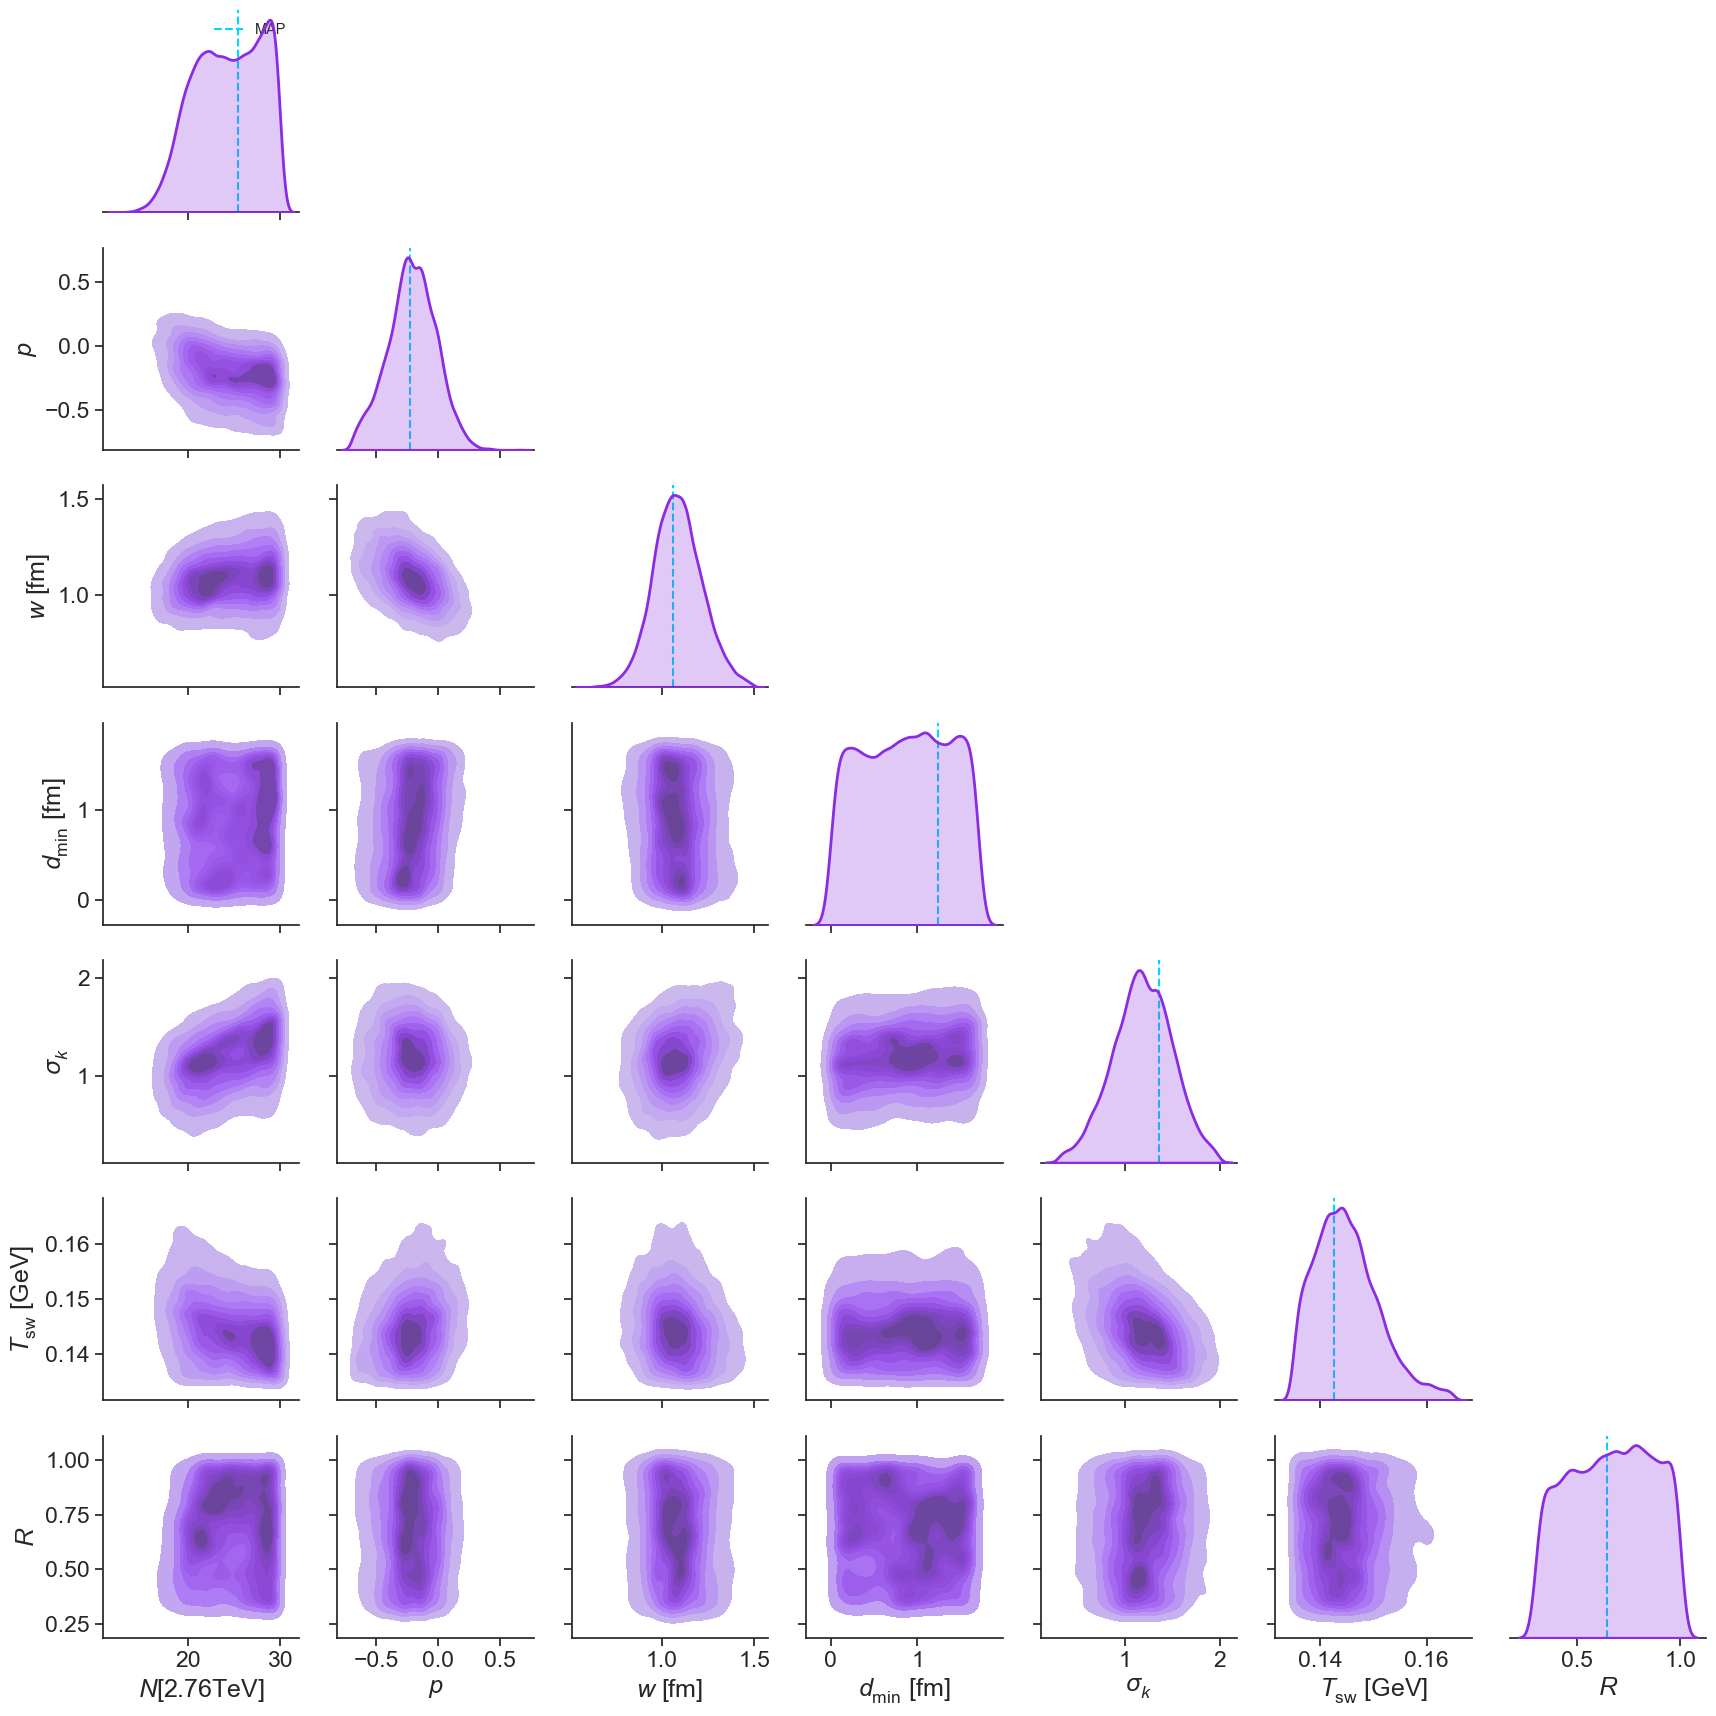

In [32]:
#### Block 30 #### Please refer to this number in your questions


sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")
map_parameters=map_values_saved.flatten()
n_samples_prior = 20000
prune = 1
#map_parameters = rslt.x
sns.set_palette('bright')
observables_to_plot=[0, 1, 2 ,3 , 4, 5, 14]
g = sns.PairGrid(samples_df.iloc[0:n_samples_prior:prune,observables_to_plot], corner=True, diag_sharey=False)
g.map_lower(sns.kdeplot, color=sns.color_palette()[4], fill=True)
#g.map_upper(sns.kdeplot, shade=True, color=sns.color_palette()[0])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[4])
for n,i in enumerate(observables_to_plot):
    ax=g.axes[n][n]
    ax.axvline(x=map_parameters[i], ls='--', c=sns.color_palette()[9], label='MAP')
    #ax.text(0.0,1,s= f'{map_parameters[i]:.3f}',fontdict={'color':sns.color_palette()[9]}, transform=ax.transAxes)
    #ax.axvline(x=truth[i], ls='--', c=sns.color_palette()[3], label = 'Truth')
    #ax.text(0.6,1,s= f'{truth[i]:.3f}',fontdict={'color':sns.color_palette()[3]}, transform=ax.transAxes)
    if n==0:
        ax.legend(loc=1,fontsize='xx-small')
plt.tight_layout()
plt.savefig(filename+"WithoutViscosity")
plt.show()

NameError: name 'save_fig' is not defined

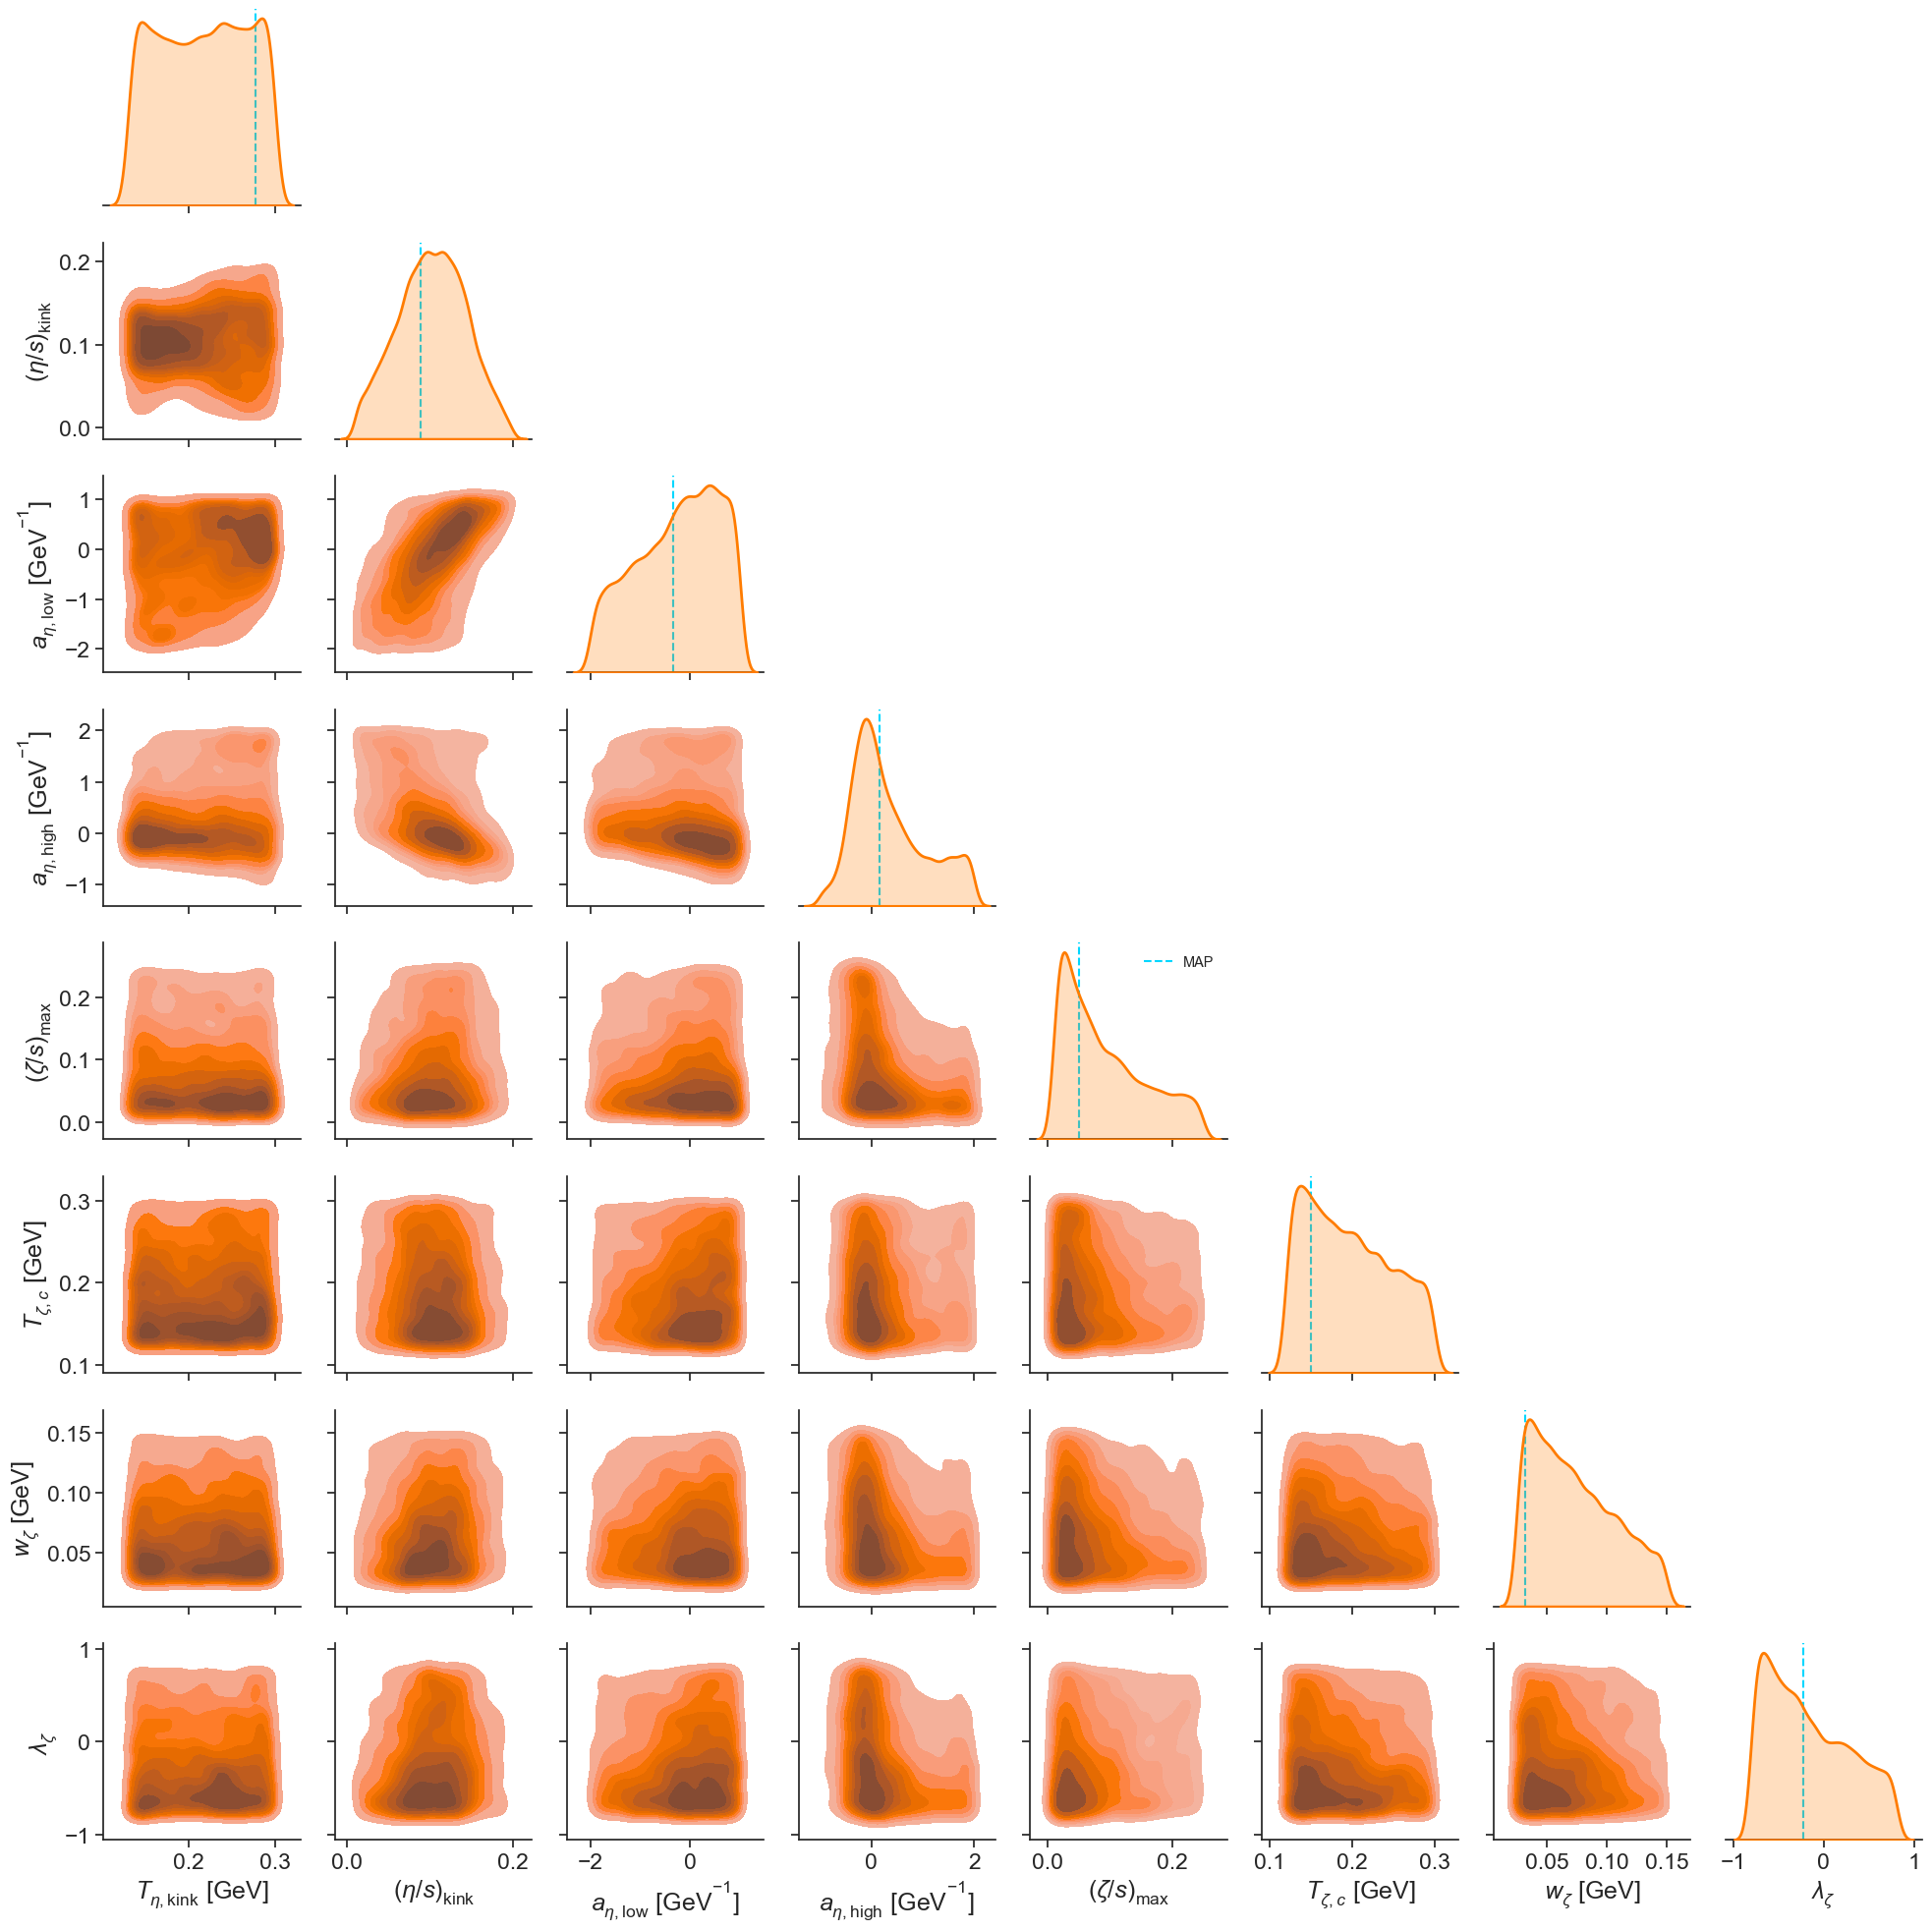

In [36]:
#### Block 31 #### Please refer to this number in your questions


sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")
#map_parameters = rslt.x
n_samples_prior = 20000
prune = 1
map_parameters=map_values_saved.flatten()
sns.set_palette('bright')
observables_to_plot=[6, 7 , 8, 9, 10, 11, 12, 13]
g = sns.PairGrid(samples_df.iloc[0:n_samples_prior:prune,observables_to_plot], corner=True, diag_sharey=False)
g.map_lower(sns.kdeplot, color=sns.color_palette()[5], fill=True)
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[1], fill=True)
for n,i in enumerate(observables_to_plot):
    ax=g.axes[n][n]
    ax.axvline(x=map_parameters[i], ls='--', c=sns.color_palette()[9], label= 'MAP')
    #ax.text(0,0.9,s= f'{map_parameters[i]:.3f}', transform=ax.transAxes)
    #ax.axvline(x=truth[i], ls='--', c=sns.color_palette()[3], label = 'Truth')
    #ax.text(0,0.8,s= f'{truth[i]:.3f}', transform=ax.transAxes)
    if n==4:
        ax.legend(loc=0,fontsize='xx-small')    
plt.tight_layout()
plt.savefig(filename+"Viscosity")
plt.show()

#### 4.7: Posterior for the viscosities

Define temperature dependent viscosity functions

In [ ]:
#### Block 33 #### Please refer to this number in your questions


def zeta_over_s(T, zmax, T0, width, asym):
    DeltaT = T - T0
    sign = 1 if DeltaT>0 else -1
    x = DeltaT/(width*(1.+asym*sign))
    return zmax/(1.+x**2)
zeta_over_s = np.vectorize(zeta_over_s)

def eta_over_s(T, T_k, alow, ahigh, etas_k):
    if T < T_k:
        y = etas_k + alow*(T-T_k)
    else:
        y = etas_k + ahigh*(T-T_k)
    if y > 0:
        return y
    else:
        return 0.
eta_over_s = np.vectorize(eta_over_s)

In [ ]:
#### Block 34 #### Please refer to this number in your questions


Tt = np.linspace(0.1, 0.4, 100)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6),
                         sharex=False, sharey=False, constrained_layout=True)
fig.suptitle("Specefic shear viscosity posterior", wrap=True)

# True temperature dependece of the viscosity

#[T_k, alow, ahigh, etas_k] = truth[[7,8,9,10]]
#true_shear = eta_over_s(Tt, T_k, alow, ahigh, etas_k)


prior_etas = []

for row in np.random.uniform(design_min, design_max,(10000,15))[:,[6,7,8,9]]:
    [T_k, etas_k, alow, ahigh] = row
    prior=[]
    for T in Tt:
        prior.append(eta_over_s(T,T_k,alow,ahigh,etas_k))
    prior_etas.append(prior)
per0_pr,per5_pr,per20_pr,per80_pr,per95_pr,per100_pr=np.percentile(prior_etas,[0,5,20,80,95,100], axis=0)

n_samples_posterior = 40000
prune = 1
posterior_etas = []
    
for row in samples_df.iloc[0:n_samples_posterior:prune,[6,7,8,9]].values:
    [T_k, etas_k, alow, ahigh] = row
    posterior=[]
    for T in Tt:
        posterior.append(eta_over_s(T,T_k,alow,ahigh,etas_k))
    posterior_etas.append(posterior)
per0,per5,per20,per80,per95,per100=np.percentile(posterior_etas,[0,5,20,80,95,100], axis=0)
axes.fill_between(Tt, per0_pr,per100_pr,color=sns.color_palette()[7], alpha=0.1, label='Prior')
axes.fill_between(Tt,per5,per95,color=sns.color_palette()[9], alpha=0.2, label='90% C.I.')
axes.fill_between(Tt,per20,per80, color=sns.color_palette()[9], alpha=0.3, label='60% C.I.')
#axes.plot(Tt, true_shear, color = 'r', label = 'Truth', linewidth=5)
#pos=np.array(prior_etas).T
#axes.violinplot(pos[1::10,:].T, positions=Tt[1::10],widths=0.03)

axes.legend(loc='upper left')
#axes.set_ylim(0,1.2)
axes.set_xlabel('T [GeV]')
axes.set_ylabel('$\eta/s$')
plt.savefig(filename+'shear_posterior')

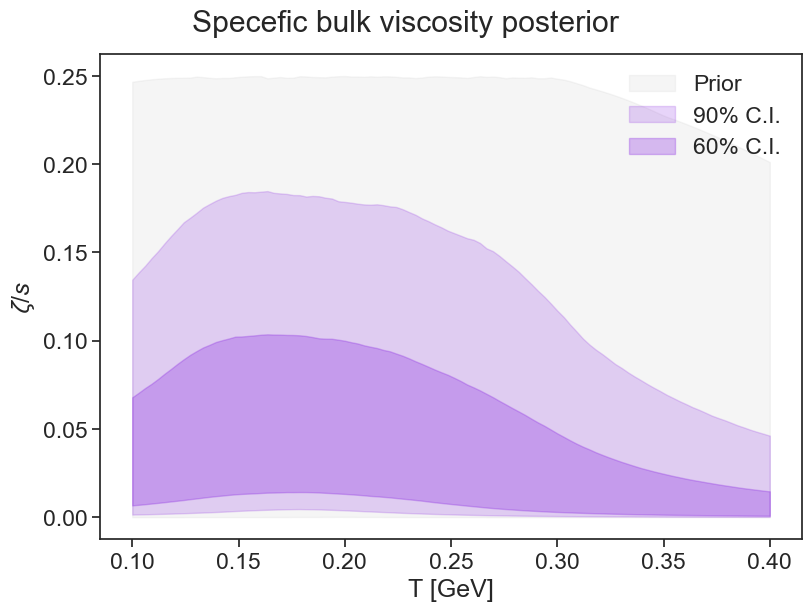

In [44]:
#### Block 35 #### Please refer to this number in your questions


Tt = np.linspace(0.1, 0.4, 100)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6),
                         sharex=False, sharey=False, constrained_layout=True)
fig.suptitle("Specefic bulk viscosity posterior", wrap=True)

# True temperature dependece of the viscosity

#[zmax, T0, width, asym] = truth[[11,12,13,14]]
#true_bulk = zeta_over_s(Tt, zmax, T0, width, asym)


prior_zetas = []

for row in np.random.uniform(design_min, design_max,(10000,15))[:,[10,11,12,13]]:
    [zmax, T0, width, asym] = row   
    prior=[]
    for T in Tt:
        prior.append(zeta_over_s(T,zmax, T0, width, asym))
    prior_zetas.append(prior)
per0_pr,per5_pr,per20_pr,per80_pr,per95_pr,per100_pr=np.percentile(prior_zetas,[0,5,20,80,95,100], axis=0)

n_samples_posterior = 40000
prune = 1
posterior_zetas = []
    
for row in samples_df.iloc[0:n_samples_posterior:prune,[10,11,12,13]].values:
    [zmax, T0, width, asym] = row   
    posterior=[]
    for T in Tt:
        posterior.append(zeta_over_s(T,zmax, T0, width, asym))
    posterior_zetas.append(posterior)
per0,per5,per20,per80,per95,per100=np.percentile(posterior_zetas,[0,5,20,80,95,100], axis=0)
axes.fill_between(Tt, per0_pr,per100_pr,color=sns.color_palette()[7], alpha=0.1, label='Prior')
axes.fill_between(Tt,per5,per95,color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
axes.fill_between(Tt,per20,per80, color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
#axes.plot(Tt, true_bulk, color = 'r', label = 'Truth', linewidth=5)

#pos=np.array(prior_zetas).T
#axes.violinplot(pos[1::10,:].T, positions=Tt[1::10],widths=0.03)

axes.legend(loc='upper right')
#axes.set_ylim(0,1.2)
axes.set_xlabel('T [GeV]')
axes.set_ylabel('$\zeta/s$')
plt.savefig(filename+'bulk_posterior')

#### 4.8: MAP predictions compared to experimental observables

In [37]:
#### Block 29 #### Please refer to this number in your questions

mm,vv=predict_observables(map_values_saved)
print(f'Shape of mean {mm.shape} and variance {vv.shape}')
np.save('MAP_mean_PCGP',mm)
np.save('MAP_var_PCGP',vv)

Shape of mean (1, 110) and variance (110, 110)


In [46]:
map_values_saved

array([25.43957904, -0.22175153,  1.06192448,  1.23536979,  1.35969649,
        0.14269371,  0.2773247 ,  0.08932065, -0.33375364,  0.16550145,
        0.05058559,  0.14942207,  0.03184175, -0.22800548,  0.64405921])

In [47]:
map_values_saved_new = np.array([28.57232622,  0.05714793,  1.18536305,  0.88569411,  0.93453349,
        0.14898859,  0.20862629,  0.11218337, -1.12039581,  1.58537076,
        0.14338342,  0.17981994,  0.09043189,  0.12831789,  0.64081075])

In [48]:
map_values_saved_new

array([28.57232622,  0.05714793,  1.18536305,  0.88569411,  0.93453349,
        0.14898859,  0.20862629,  0.11218337, -1.12039581,  1.58537076,
        0.14338342,  0.17981994,  0.09043189,  0.12831789,  0.64081075])

In [49]:
predict_observables(map_values_saved_new)

(array([[1.95104428e+03, 1.60608316e+03, 1.22501528e+03, 8.30380872e+02,
         5.54593876e+02, 3.54416123e+02, 2.11670004e+02, 1.15630376e+02,
         2.91685991e+03, 2.61570156e+03, 2.36818951e+03, 2.16225041e+03,
         1.96851412e+03, 1.78481458e+03, 1.62696865e+03, 1.47101305e+03,
         1.31945068e+03, 1.19512203e+03, 1.07551691e+03, 9.64631131e+02,
         8.69681432e+02, 7.78712031e+02, 6.94613538e+02, 6.15968044e+02,
         5.12861416e+02, 3.95646420e+02, 2.97649041e+02, 2.17605954e+02,
         1.56638498e+02, 1.08512438e+02, 1.76349362e+03, 1.45172647e+03,
         1.10750305e+03, 7.52154991e+02, 5.04211106e+02, 3.24054408e+02,
         1.95115370e+02, 1.07573808e+02, 3.09658779e+02, 2.56021174e+02,
         1.96692886e+02, 1.34778251e+02, 9.10039524e+01, 5.89505240e+01,
         3.57717962e+01, 1.99290908e+01, 8.96975700e+01, 7.47066843e+01,
         5.80712154e+01, 4.04135729e+01, 2.77348546e+01, 1.83624994e+01,
         1.15449300e+01, 6.73217110e+00, 6.26535200

In [50]:
predict_observables(map_values_saved)

(array([[1.45294980e+03, 1.17955713e+03, 8.86462785e+02, 5.94463741e+02,
         3.92580211e+02, 2.47995461e+02, 1.46665905e+02, 7.78164263e+01,
         1.97732551e+03, 1.76158498e+03, 1.59108490e+03, 1.44378327e+03,
         1.31023304e+03, 1.18593459e+03, 1.07780378e+03, 9.73516436e+02,
         8.74998725e+02, 7.89117281e+02, 7.11676044e+02, 6.39550677e+02,
         5.74851629e+02, 5.13709852e+02, 4.58358502e+02, 4.08152741e+02,
         3.39921594e+02, 2.61568626e+02, 1.97955813e+02, 1.45067359e+02,
         1.03355694e+02, 7.08451903e+01, 1.34004630e+03, 1.08701801e+03,
         8.16410253e+02, 5.47788922e+02, 3.62456902e+02, 2.29759703e+02,
         1.36601704e+02, 7.29435996e+01, 2.32117115e+02, 1.89350754e+02,
         1.43276053e+02, 9.70403629e+01, 6.47462220e+01, 4.13574488e+01,
         2.47977559e+01, 1.33601737e+01, 6.39222126e+01, 5.26082055e+01,
         4.03259663e+01, 2.77156552e+01, 1.87214071e+01, 1.21199328e+01,
         7.40840233e+00, 4.10233882e+00, 5.38754351

In [51]:
mm

array([[1.45294980e+03, 1.17955713e+03, 8.86462785e+02, 5.94463741e+02,
        3.92580211e+02, 2.47995461e+02, 1.46665905e+02, 7.78164263e+01,
        1.97732551e+03, 1.76158498e+03, 1.59108490e+03, 1.44378327e+03,
        1.31023304e+03, 1.18593459e+03, 1.07780378e+03, 9.73516436e+02,
        8.74998725e+02, 7.89117281e+02, 7.11676044e+02, 6.39550677e+02,
        5.74851629e+02, 5.13709852e+02, 4.58358502e+02, 4.08152741e+02,
        3.39921594e+02, 2.61568626e+02, 1.97955813e+02, 1.45067359e+02,
        1.03355694e+02, 7.08451903e+01, 1.34004630e+03, 1.08701801e+03,
        8.16410253e+02, 5.47788922e+02, 3.62456902e+02, 2.29759703e+02,
        1.36601704e+02, 7.29435996e+01, 2.32117115e+02, 1.89350754e+02,
        1.43276053e+02, 9.70403629e+01, 6.47462220e+01, 4.13574488e+01,
        2.47977559e+01, 1.33601737e+01, 6.39222126e+01, 5.26082055e+01,
        4.03259663e+01, 2.77156552e+01, 1.87214071e+01, 1.21199328e+01,
        7.40840233e+00, 4.10233882e+00, 5.38754351e-01, 5.391036

No handles with labels found to put in legend.
/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


Done


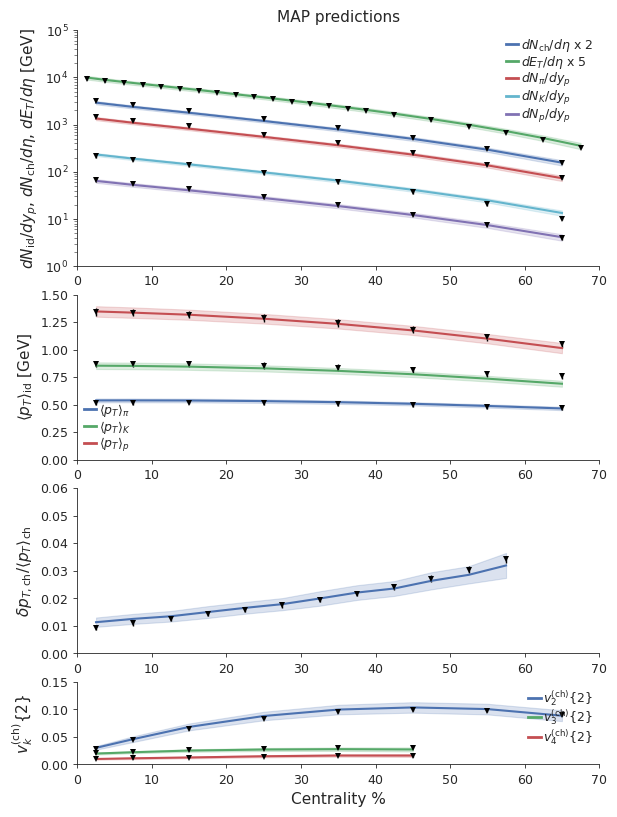

In [31]:
#### Block 32 #### Please refer to this number in your questions


# height_ratios = [1.8, 1.2, 1.5, 1.]
height_ratios = [2, 1.4, 1.4, 0.7]
column = 1
fig, axes = plt.subplots(nrows=4, ncols=column, figsize=(6, 8), squeeze=False, 
                         gridspec_kw={'height_ratios': height_ratios})

for row, obs_group in enumerate(obs_groups.keys()):
    for obs, color in zip(obs_groups[obs_group], colors):
        expt_label = 'ALICE'
        
        axes[row][0].tick_params(labelsize=9)
       # axes[row][1].tick_params(labelsize=9)
        
        scale = 1.0
        
        if obs_group == 'yields':
            axes[row][0].set_yscale('log')
          #  axes[row][1].set_yscale('log')
            
            axes[row][0].set_title("MAP predictions", fontsize = 11)
          #  axes[row][1].set_title("VAH + PTMA", fontsize = 11)
           
            if obs == 'dET_deta':
                scale = 5.
            if obs == 'dNch_deta':
                scale = 2.
        
        axes[row][0].set_ylabel(obs_group_labels[obs_group], fontsize = 11)
        
        xbins = np.array(obs_cent_list['Pb-Pb-2760'][obs])
        x = (xbins[:,0] + xbins[:,1]) / 2.

        Y1 = mm[0,index[obs][0]:index[obs][1]]
        Yerr1 = np.sqrt(vv.diagonal()[index[obs][0]:index[obs][1]])
        
        #Y2 = Ymodel2['Pb-Pb-2760'][obs]['mean'][0][0]
        #Yerr2 = Ymodel2['Pb-Pb-2760'][obs]['err'][0][0]
        
        label = obs_tex_labels[obs]
            
        axes[row][0].plot(x, Y1*scale, color = color, label = label, lw = 1.5)
        axes[row][0].fill_between(x, (Y1-Yerr1)*scale, (Y1+Yerr1)*scale, color=color, alpha=0.2)
        
       # axes[row][1].plot(x, Y2*scale, color = color, label = label, lw = 1.5)
       # axes[row][1].fill_between(x, (Y2-Yerr2)*scale, (Y2+Yerr2)*scale, color=color, alpha=0.2)
        
        exp_mean = y_exp[index[obs][0]:index[obs][1]]
        exp_err = np.sqrt(y_exp_variance[index[obs][0]:index[obs][1]])
        #exp_mean = Yexp['Pb-Pb-2760'][obs]['mean'][0]
        #exp_err = Yexp['Pb-Pb-2760'][obs]['err'][0]
    
        axes[row][0].errorbar(x, exp_mean*scale, exp_err, color='black', fmt='v', markersize='4', elinewidth=1)
        #axes[row][1].errorbar(x, exp_mean*scale, exp_err, color='black', fmt='v', markersize='4', elinewidth=1)
            

        
    leg = axes[row][0].legend(fontsize=9, borderpad=0, labelspacing=0, handlelength=1, handletextpad=0.2)
    
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)
        legobj.set_alpha(1.0)

    axes[row][0].set_xlim(0, 70)

    if obs_group == 'yields':
        axes[row][0].set_ylim(1, 1e5)
       # axes[row][1].set_ylim(1, 1e4)
    if obs_group == 'mean_pT':
        axes[row][0].set_ylim(0., 1.5)
       # axes[row][1].set_ylim(0., 1.5)
    if obs_group == 'fluct':
        axes[row][0].set_ylim(0.0, 0.06)
      #  axes[row][1].set_ylim(0.0, 0.04)
    if obs_group == 'flows':
        axes[row][0].set_ylim(0.0, 0.15)
       # axes[row][1].set_ylim(0.0, 0.12)
    if axes[row][0].is_last_row():
        axes[row][0].set_xlabel('Centrality %', fontsize = 11)
       # axes[row][1].set_xlabel('Centrality %', fontsize = 11)
        
plt.tight_layout(True)
# set_tight(fig, rect=[0, 0, 1, 0.95])
set_tight(fig, rect=[0, 0, 1, 1])
plt.savefig("MAP_prediction.png")

print("Done")






In [35]:
sns.set_context('poster')
def generate_plots(obs_group, obs):
    """Generates plots to compare between simulations
    
    Parameters
    ----------
    parameter_array: array of strings
    each string has the form -> 'etaA_mptB_lC'
    A = 0 for eta/s 3/4pi, A = 1 for eta/s infinity.
    B is the magnitude of initial momentem anisotrpy.
    C is the correlation length the scale of initial random fields.
    """
    observables = {}
    observables_er = {}
    fig, ax = plt.subplots(figsize=(10,10))
    
    xbins = np.array(obs_cent_list['Pb-Pb-2760'][obs])
    x = (xbins[:,0] + xbins[:,1]) / 2.

    Y1 = mm[0,index[obs][0]:index[obs][1]]
    Yerr1 = np.sqrt(vv.diagonal()[index[obs][0]:index[obs][1]])
    ax.errorbar(x, Y1,Yerr1)
    exp_mean = y_exp[index[obs][0]:index[obs][1]]
    exp_err = np.sqrt(y_exp_variance[index[obs][0]:index[obs][1]])
    ax.errorbar(x, exp_mean,exp_err,color='black', fmt='v')
    ax.legend()
    ax.set_xlabel('Centrality')
    ax.set_ylabel(obs_tex_labels[obs])
    plt.tight_layout(True)

No handles with labels found to put in legend.
/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


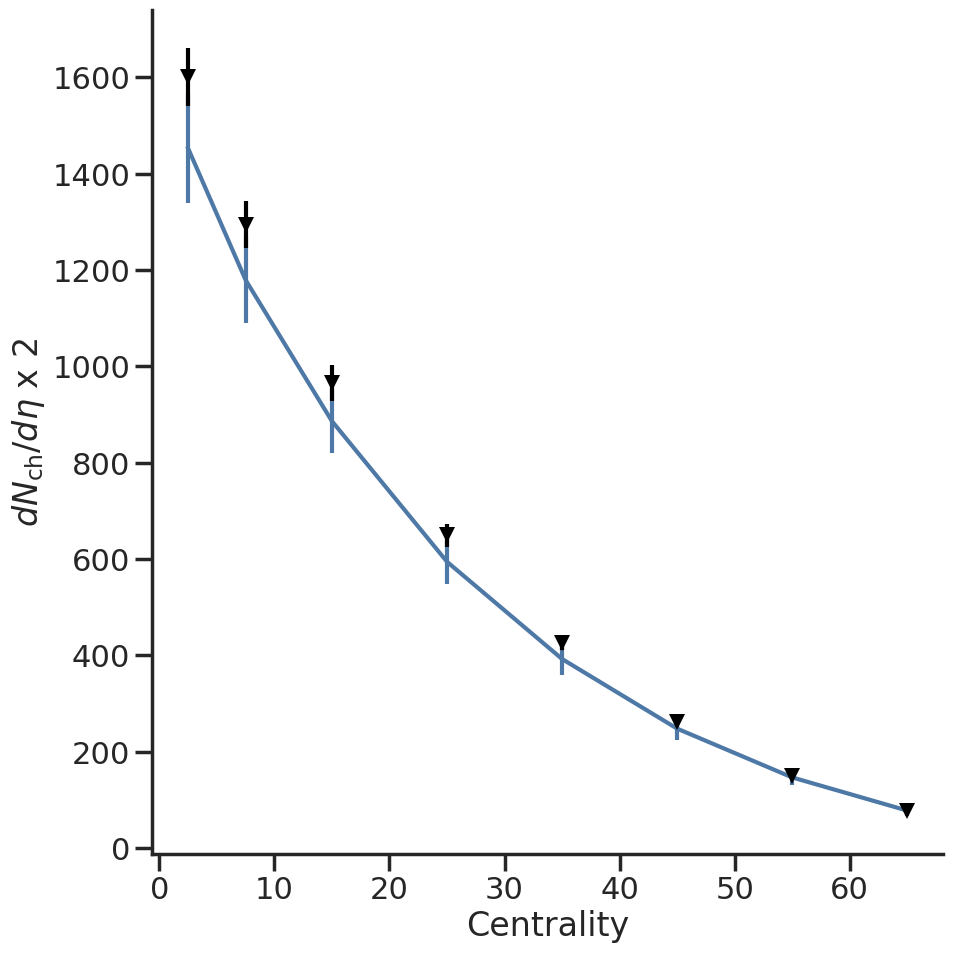

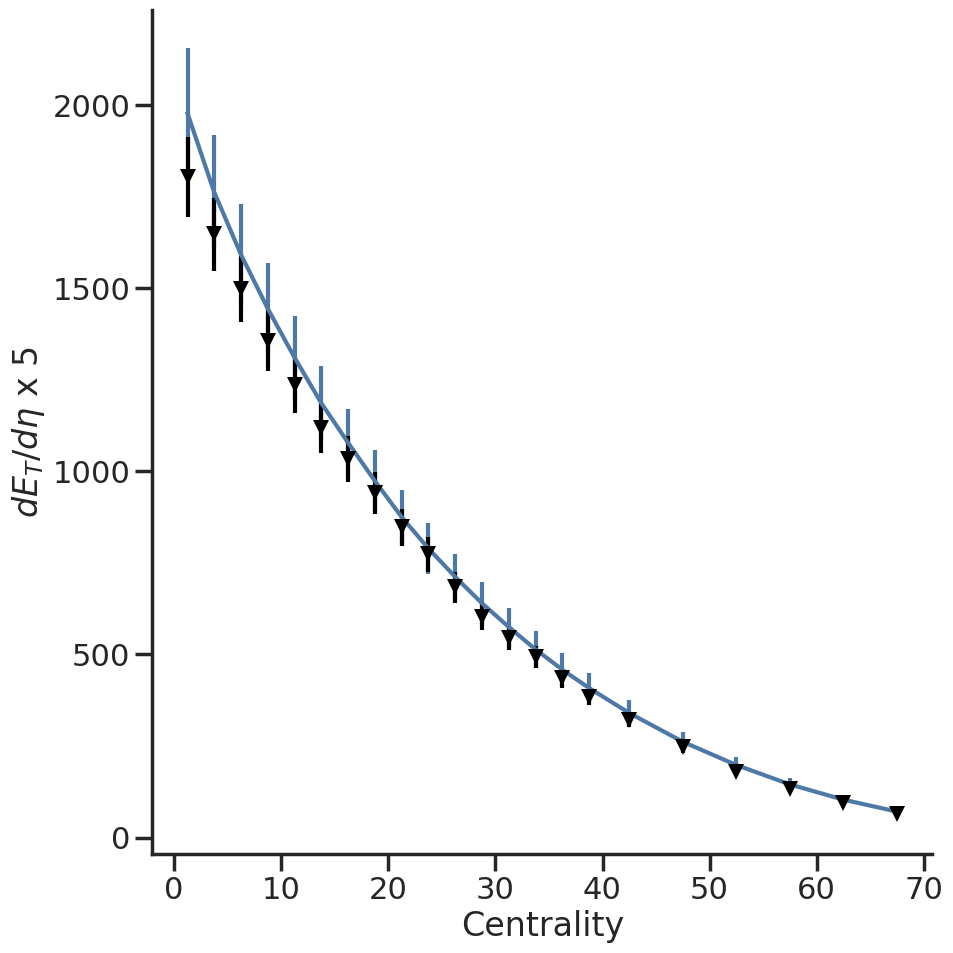

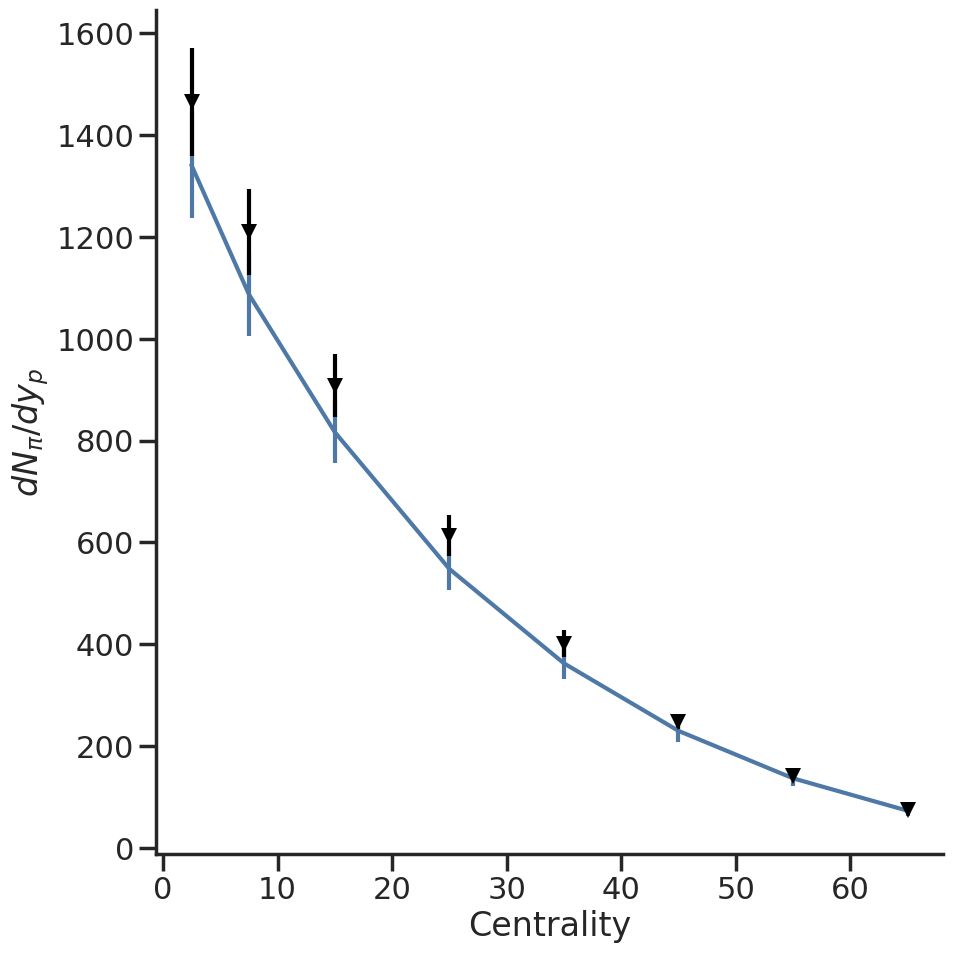

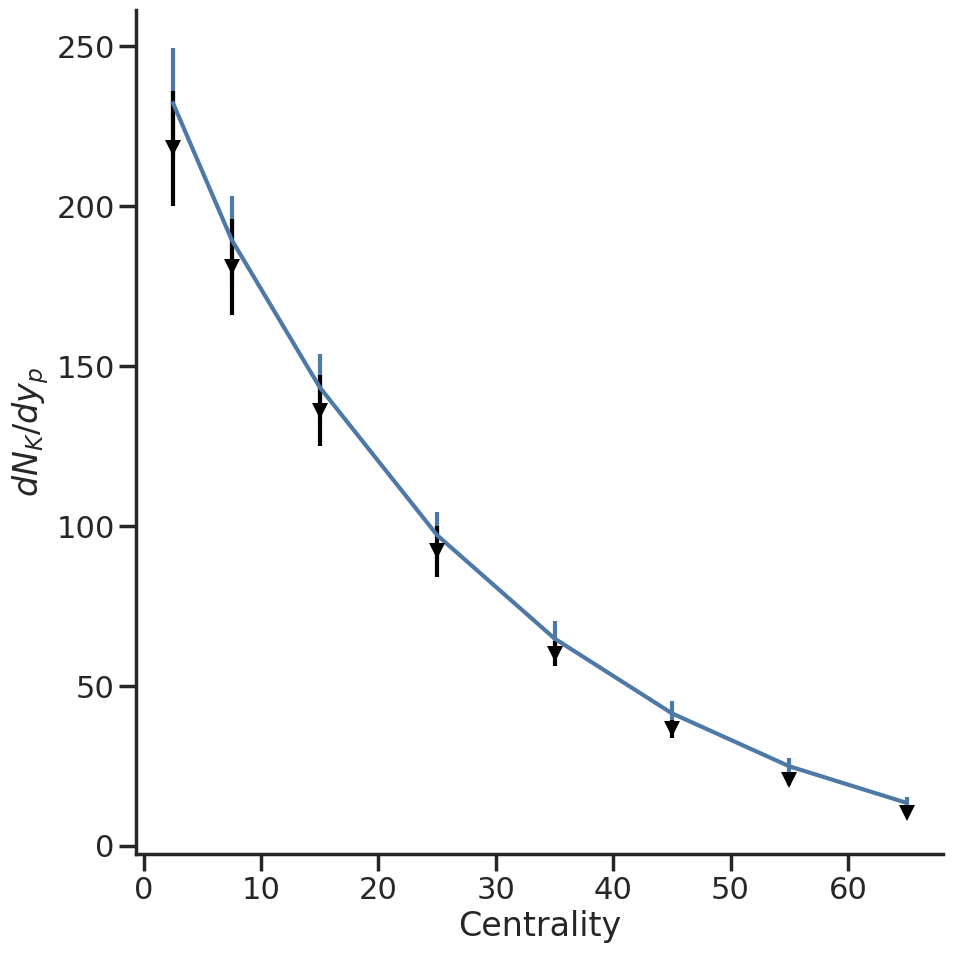

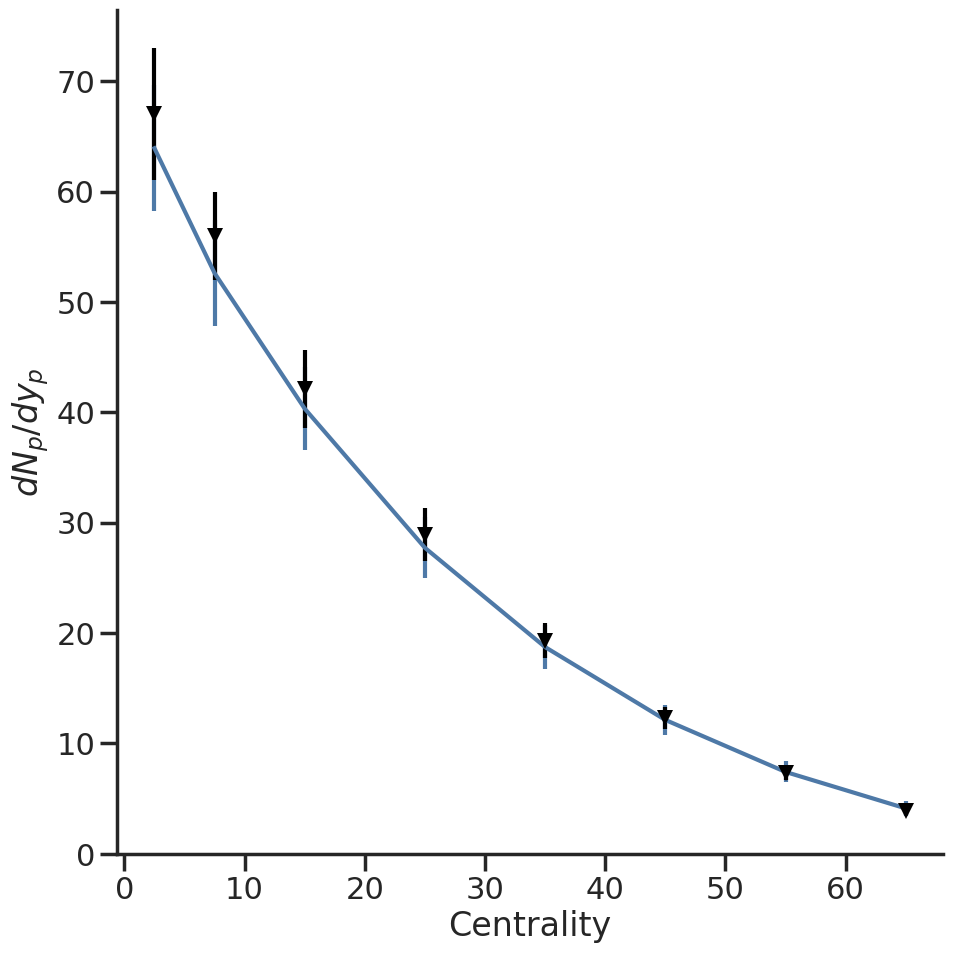

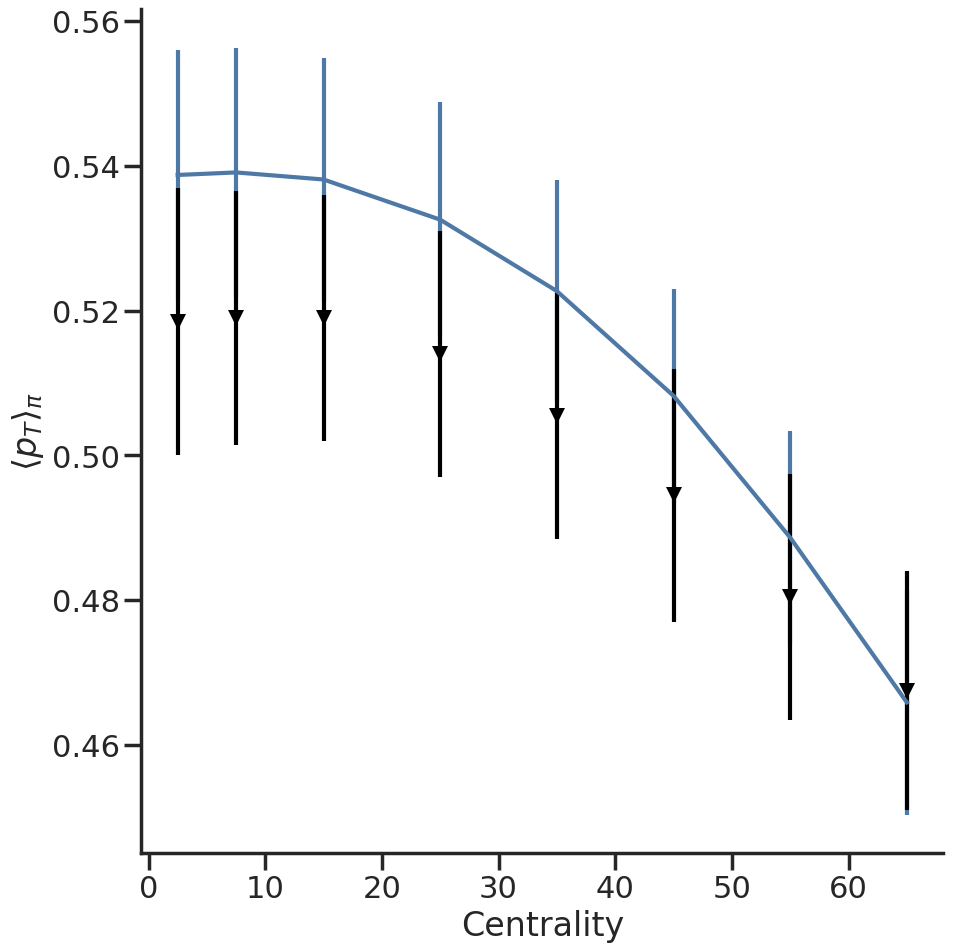

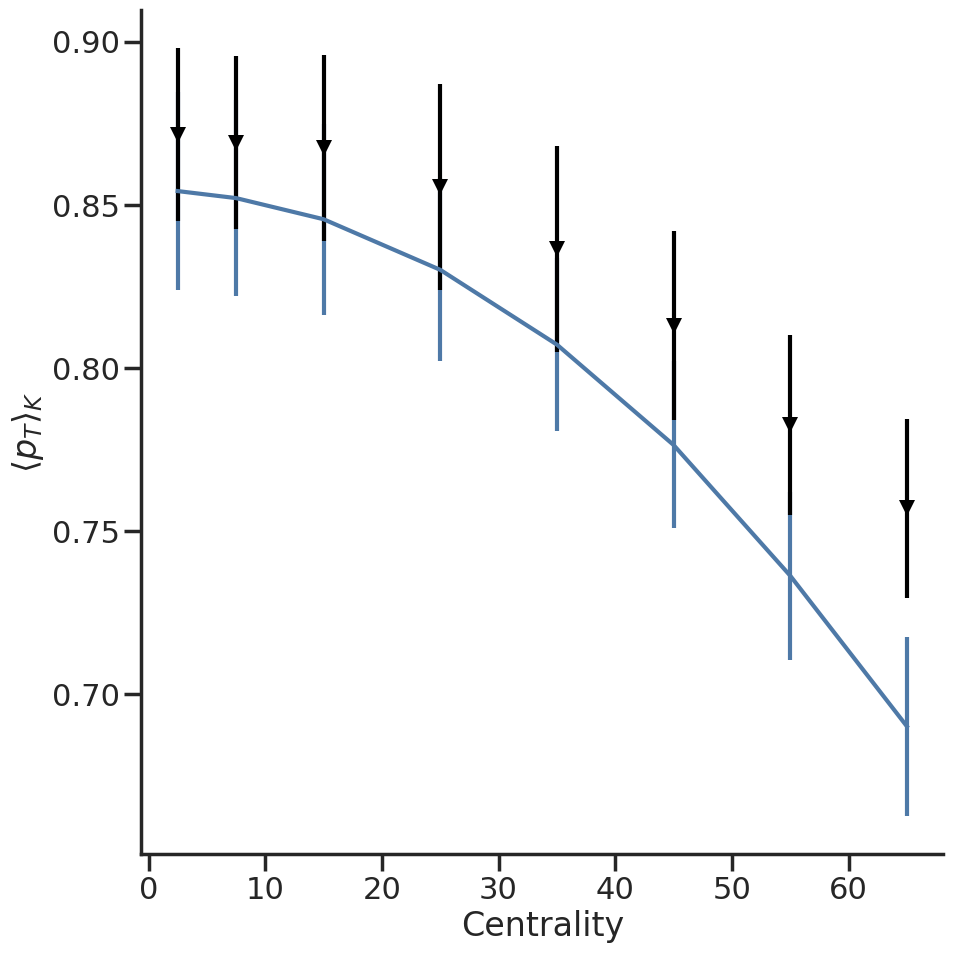

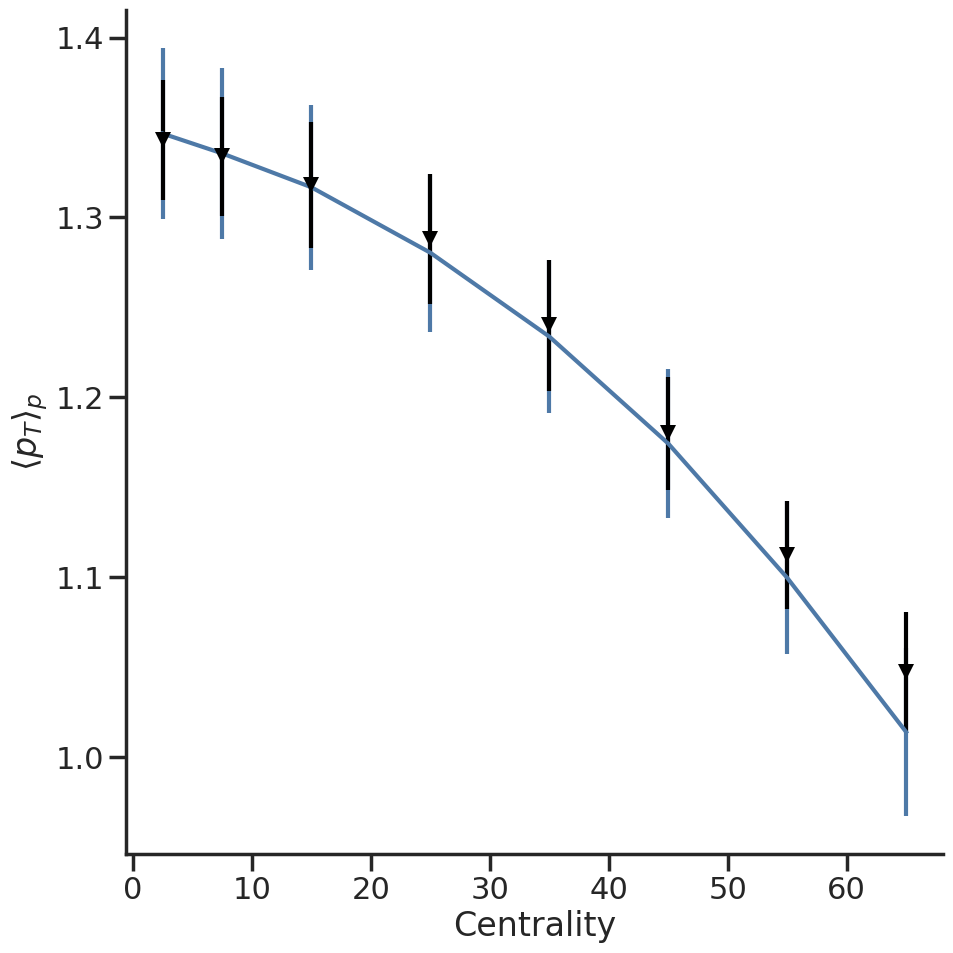

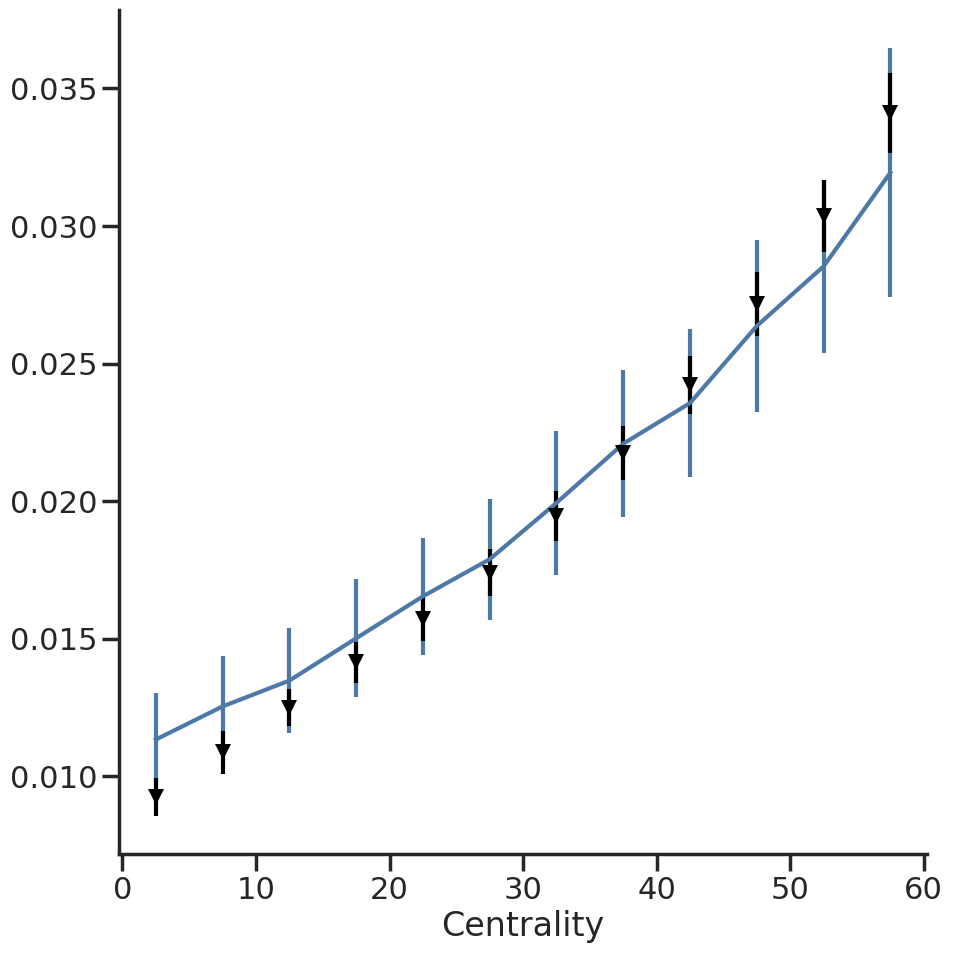

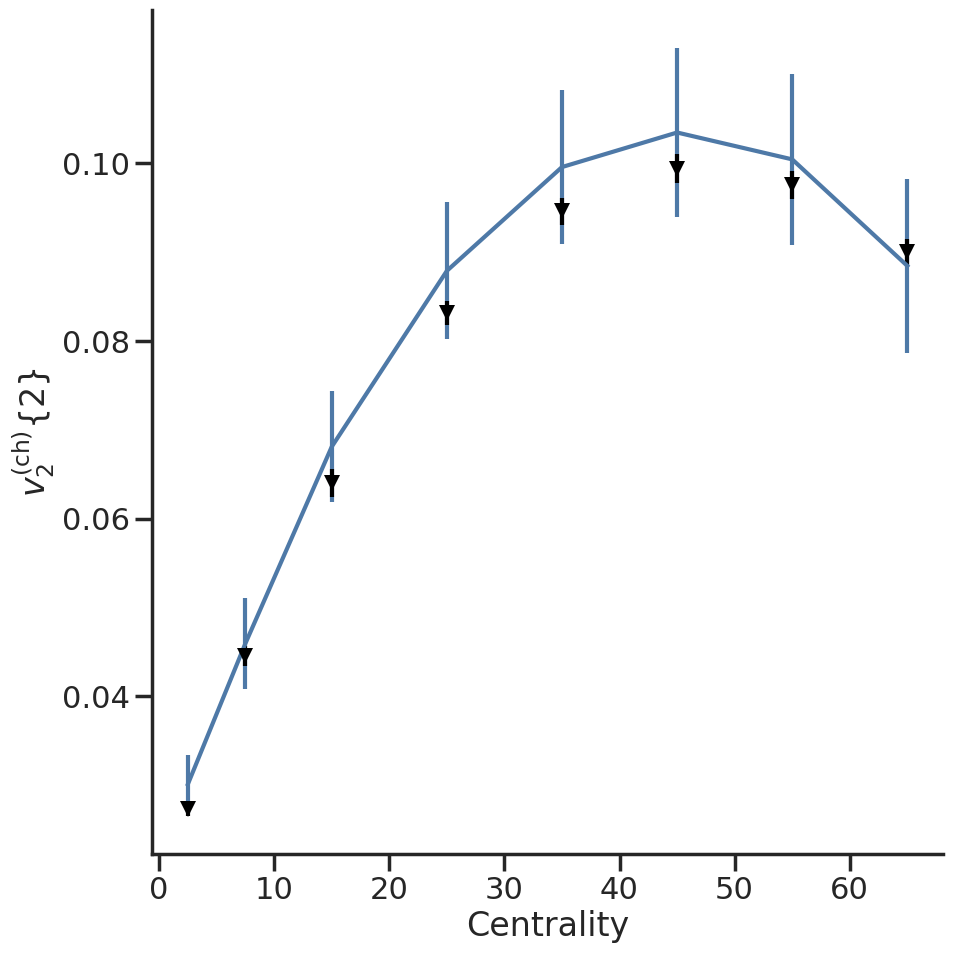

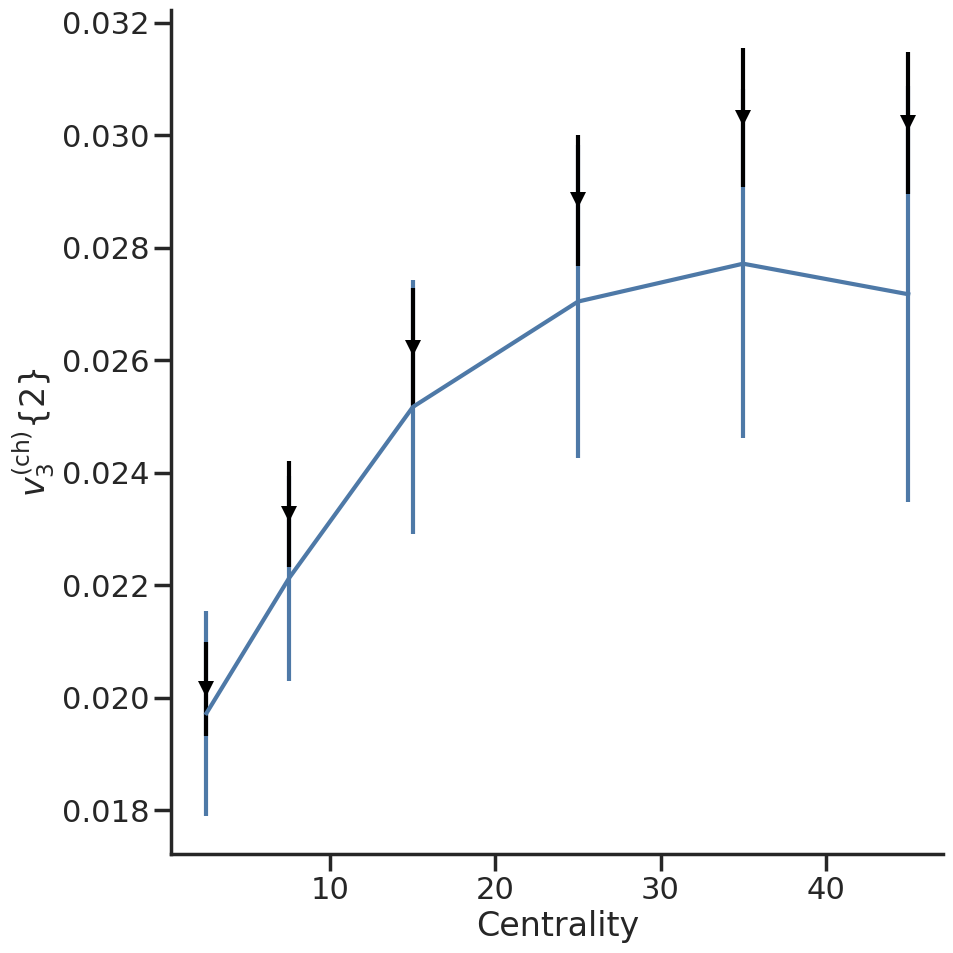

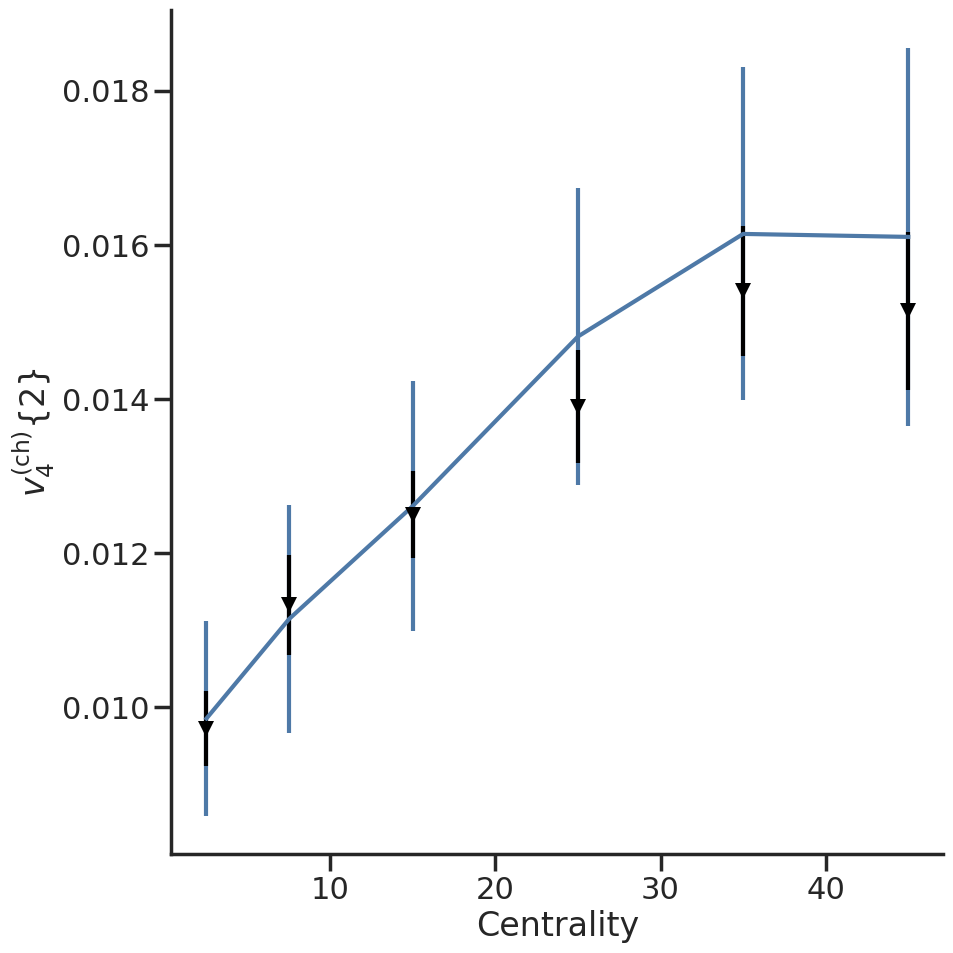

In [36]:
for og in obs_groups:
    for obs in obs_groups[og]:
        generate_plots(og,obs)

# Homework 
> Emulator validation

> Prior predictive checks

> Tests for MCMC convergence

> Bayesian parameter inference with the real experimental data

> Posterior predictive checks 


# <center> Thank You! 

# <center> Good Luck!!